# MIMIC-II IAC Introduction

This tutorial explores the **M**ultiparameter **I**ntelligent **M**onitoring in **I**ntensive **C**are II (**MIMIC-II**) **I**ndwelling **A**rterial **C**atheters (**IAC**) dataset, as subset derived from MIMIC-II, the publicly-accessible critical care database. The database was created for the purpose of a case study in the book ["Secondary Analysis of Electronic Health Records"](https://link.springer.com/book/10.1007/978-3-319-43742-2), published by Springer in 2016. In particular, the MIMIC-II IAC dataset was used throughout Chapter 16 (Data Analysis) by Raffa J. et al. to investigate the effectiveness of indwelling arterial catheters in hemodynamically stable patients with respiratory failure for mortality outcomes. 

More details on the dataset such as all included features and their description can be found [here](https://physionet.org/content/mimic2-iaccd/1.0/).

In [56]:
import warnings

warnings.filterwarnings("ignore")

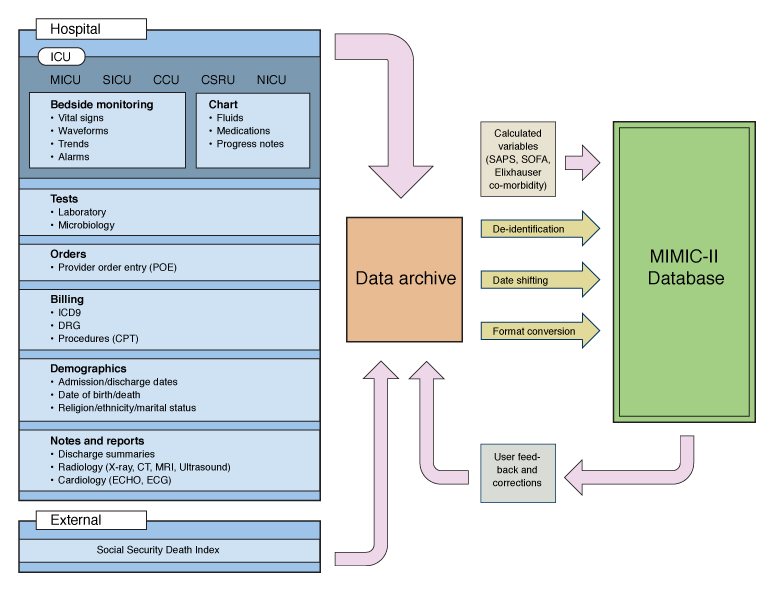

In [57]:
from IPython.display import Image

Image(filename="images/MIMIC-II-database-structure.png", width=400)

In this tutorial we want to explore the MIMIC-II IAC dataset using ehrapy to identify patient groups and their associated features. 

The major steps of an analysis with ehrapy include:

1. Preprocessing and quality control (QC)
   
2. Dimensionality reduction
   
3. Batch effect identification
   
4. Clustering
   
5. Additional downstream analysis

Before we start with the analysis of the MIMIC-II IAC dataset, we set up our environment including the import of packages and preparation of the dataset.

_________________

## Environment setup

Ensure that the latest version of ehrapy is installed. A list of all dependency versions can be found at the end of this tutorial.

In [58]:
import warnings
warnings.filterwarnings("ignore")

import ehrapy as ep
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### MIMIC-II IAC dataset loading

ehrapy offers several [datasets](https://ehrapy.readthedocs.io/en/latest/usage/usage.html#data) in AnnData format that can be used out of the box.
In this tutorial we will use the MIMIC-II IAC dataset with unencoded features. ehrapy's default encoding is a simple one-hot encoding in this case. More details on encoding can be seen in the next step.

In [59]:
adata = ep.dt.mimic_2(encoded=False)
adata

AnnData object with n_obs × n_vars = 1776 × 46
    layers: 'original'

The MIMIC-II dataset has 1776 patients with 46 features. 
<br>
Now that we have our AnnData file ready, we can start the analysis using ehrapy and the first step will be to preprocess the dataset.

## Analysis using ehrapy

### Preprocessing

The dataset contains 46 features, as previously mentioned. We distinguish between numerical, categorical, and date features. First, we need to clarify which features fall into what category. Ehrapy offers the method `infer_feature_types` for this, which guesses the type of each feature. It is important to always check that the type guesses are correct, and if not, to correct them.

In [60]:
ep.ad.infer_feature_types(adata)

! Features 'aline_flg', 'gender_num', 'service_num', 'day_icu_intime_num', 'hour_icu_intime', 'hosp_exp_flg', 'icu_exp_flg', 'day_28_flg', 'censor_flg', 'sepsis_flg', 'chf_flg', 'afib_flg', 'renal_flg', 'liver_flg', 'copd_flg', 'cad_flg', 'stroke_flg', 'mal_flg', 'resp_flg' were detected as categorical features stored numerically.Please verify and correct using `ep.ad.replace_feature_types` if necessary.


 Detected feature types for AnnData object with 1776 obs and 46 vars
╠══ 📅 Date features
╠══ 📐 Numerical features
║   ╠══ abg_count
║   ╠══ age
║   ╠══ bmi
║   ╠══ bun_first
║   ╠══ chloride_first
║   ╠══ creatinine_first
║   ╠══ hgb_first
║   ╠══ hospital_los_day
║   ╠══ hr_1st
║   ╠══ icu_los_day
║   ╠══ iv_day_1
║   ╠══ map_1st
║   ╠══ mort_day_censored
║   ╠══ pco2_first
║   ╠══ platelet_first
║   ╠══ po2_first
║   ╠══ potassium_first
║   ╠══ sapsi_first
║   ╠══ sodium_first
║   ╠══ sofa_first
║   ╠══ spo2_1st
║   ╠══ tco2_first
║   ╠══ temp_1st
║   ╠══ wbc_first
║   ╚══ weight_first
╚══ 🗂️ Categorical features
    ╠══ afib_flg (2 categories)
    ╠══ aline_flg (2 categories)
    ╠══ cad_flg (2 categories)
    ╠══ censor_flg (2 categories)
    ╠══ chf_flg (2 categories)
    ╠══ copd_flg (2 categories)
    ╠══ day_28_flg (2 categories)
    ╠══ day_icu_intime (7 categories)
    ╠══ day_icu_intime_num (7 categories)
    ╠══ gender_num (2 categories)
    ╠══ hosp_exp_flg (2 categories)
    ╠══ hour_icu_intime (24 categories)
    ╠══ icu_exp_flg (2 categories)
    ╠══ liver_flg (2 categories)
    ╠══ mal_flg (2 categories)
    ╠══ renal_flg (2 categories)
    ╠══ resp_flg (2 categories)
    ╠══ sepsis_flg (1 categories)
    ╠══ service_num (2 categories)
    ╠══ service_unit (3 categories)
    ╚══ stroke_flg (2 categories)

When checking the detected feature types above, we find that for this dataset, all features were detected correctly. If you find that for your dataset this isn't the case, you can correct the feature type using `ep.ad.correct_feature_types`.

Categorical features could either already be stored numerically (e.g., as `0`/`1` for flags) or as another type such as strings. Such categorical features need an encoding. Here, we identify **service_unit** and **day_icu_intime** as categorical features stored non-numerically. We will therefore encode them first with one-hot encoding. This ensures that no ordering is preserved for the respective features. ehrapy also offers other [encoding](https://ehrapy.readthedocs.io/en/latest/usage/usage.html#encoding) functions.

In [61]:
adata = ep.pp.encode(adata, encodings={"one-hot": ["service_unit", "day_icu_intime"]})

Output()

In [62]:
adata

AnnData object with n_obs × n_vars = 1776 × 54
    obs: 'service_unit', 'day_icu_intime'
    var: 'feature_type', 'unencoded_var_names', 'encoding_mode'
    layers: 'original'

After one-hot encoding the two features, we have expanded our matrix from 46 to 54 features.

To verify that we have encoded all features correctly and are ready to proceed, we can use the *feature_type_overview()* function.

In [63]:
ep.ad.feature_type_overview(adata)

 Detected feature types for AnnData object with 1776 obs and 54 vars
╠══ 📅 Date features
╠══ 📐 Numerical features
║   ╠══ abg_count
║   ╠══ age
║   ╠══ bmi
║   ╠══ bun_first
║   ╠══ chloride_first
║   ╠══ creatinine_first
║   ╠══ hgb_first
║   ╠══ hospital_los_day
║   ╠══ hr_1st
║   ╠══ icu_los_day
║   ╠══ iv_day_1
║   ╠══ map_1st
║   ╠══ mort_day_censored
║   ╠══ pco2_first
║   ╠══ platelet_first
║   ╠══ po2_first
║   ╠══ potassium_first
║   ╠══ sapsi_first
║   ╠══ sodium_first
║   ╠══ sofa_first
║   ╠══ spo2_1st
║   ╠══ tco2_first
║   ╠══ temp_1st
║   ╠══ wbc_first
║   ╚══ weight_first
╚══ 🗂️ Categorical features
    ╠══ afib_flg (2 categories)
    ╠══ aline_flg (2 categories)
    ╠══ cad_flg (2 categories)
    ╠══ censor_flg (2 categories)
    ╠══ chf_flg (2 categories)
    ╠══ copd_flg (2 categories)
    ╠══ day_28_flg (2 categories)
    ╠══ day_icu_intime (7 categories); one-hot encoded
    ╠══ day_icu_intime_num (7 categories)
    ╠══ gender_num (2 categories)
    ╠══ hosp_exp_flg (2 categories)
    ╠══ hour_icu_intime (24 categories)
    ╠══ icu_exp_flg (2 categories)
    ╠══ liver_flg (2 categories)
    ╠══ mal_flg (2 categories)
    ╠══ renal_flg (2 categories)
    ╠══ resp_flg (2 categories)
    ╠══ sepsis_flg (1 categories)
    ╠══ service_num (2 categories)
    ╠══ service_unit (3 categories); one-hot encoded
    ╚══ stroke_flg (2 categories)

### Quality Control (QC)

#### Demographics distribution

To see if we have strong differences by demographics, we can check these features in a violin plot.

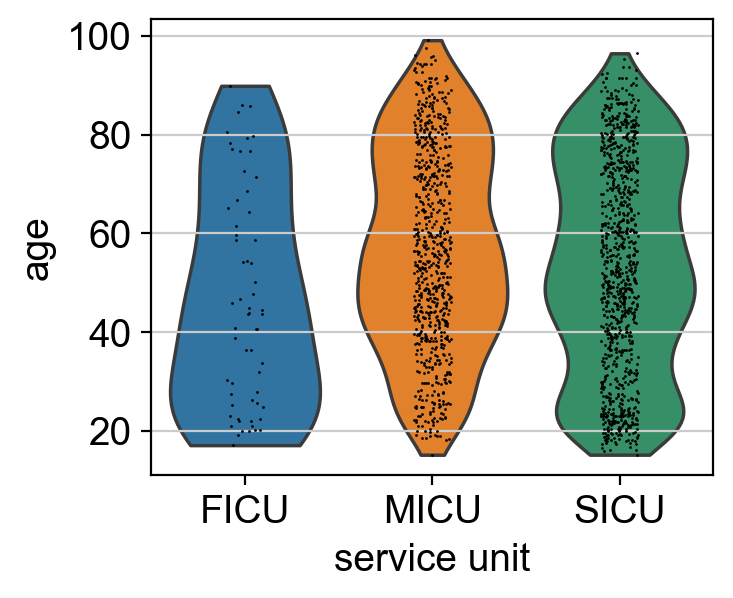

In [64]:
ep.settings.set_figure_params(figsize=(4, 3), dpi=100)
ep.pl.violin(adata, keys=["age"], groupby="service_unit")

#### Missing values

ehrapy's `pp.qc_metrics()` function will calculate several useful metrics such as the absolute number and percentages of missing values and properties like the mean/median/min/max of all features. The percentage of missing values is important as features with too many missing values should not be included. 

In [65]:
obs_metric, var_metrics = ep.pp.qc_metrics(adata)

In [66]:
obs_metric

missing_values_abs  missing_values_pct
0                      0            0.000000
1                     12           22.222222
2                      0            0.000000
3                      3            5.555556
4                      0            0.000000
...                  ...                 ...
1771                   1            1.851852
1772                   1            1.851852
1773                   3            5.555556
1774                   1            1.851852
1775                   1            1.851852

[1776 rows x 2 columns]

In [67]:
var_metrics

missing_values_abs  missing_values_pct  \
ehrapycat_service_unit_FICU                          0            0.000000   
ehrapycat_service_unit_MICU                          0            0.000000   
ehrapycat_service_unit_SICU                          0            0.000000   
ehrapycat_day_icu_intime_Friday                      0            0.000000   
ehrapycat_day_icu_intime_Monday                      0            0.000000   
ehrapycat_day_icu_intime_Saturday                    0            0.000000   
ehrapycat_day_icu_intime_Sunday                      0            0.000000   
ehrapycat_day_icu_intime_Thursday                    0            0.000000   
ehrapycat_day_icu_intime_Tuesday                     0            0.000000   
ehrapycat_day_icu_intime_Wednesday                   0            0.000000   
aline_flg                                            0            0.000000   
icu_los_day                                          0            0.000000   
hospital_los_day                                     0            0.000000   
age                                                  0            0.000000   
gender_num                                           1            0.056306   
weight_first                                       110            6.193694   
bmi                                                466           26.238739   
sapsi_first                                         85            4.786036   
sofa_first                                           6            0.337838   
service_num                                          0            0.000000   
day_icu_intime_num                                   0            0.000000   
hour_icu_intime                                      0            0.000000   
hosp_exp_flg                                         0            0.000000   
icu_exp_flg                                          0            0.000000   
day_28_flg                                           0            0.000000   
mort_day_censored                                    0            0.000000   
censor_flg                                           0            0.000000   
sepsis_flg                                           0            0.000000   
chf_flg                                              0            0.000000   
afib_flg                                             0            0.000000   
renal_flg                                            0            0.000000   
liver_flg                                            0            0.000000   
copd_flg                                             0            0.000000   
cad_flg                                              0            0.000000   
stroke_flg                                           0            0.000000   
mal_flg                                              0            0.000000   
resp_flg                                             0            0.000000   
map_1st                                              0            0.000000   
hr_1st                                               0            0.000000   
temp_1st                                             3            0.168919   
spo2_1st                                             0            0.000000   
abg_count                                            0            0.000000   
wbc_first                                            8            0.450450   
hgb_first                                            8            0.450450   
platelet_first                                       8            0.450450   
sodium_first                                         5            0.281532   
potassium_first                                      5            0.281532   
tco2_first                                           5            0.281532   
chloride_first                                       5            0.281532   
bun_first                                            5            0.281532   
creatinine_first                                     6    

All properties will be added to the respective layers. Categorical features can be found in the **obs** layer, while numerical features are in the **var** layer of the AnnData object. When inspecting both layers, we see that our QC properties were added for each feature if possible.

In [68]:
adata.obs.head(4)

service_unit day_icu_intime  missing_values_abs  missing_values_pct
0         SICU      Friday                      0            0.000000
1         MICU      Saturday                   12           22.222222
2         MICU      Friday                      0            0.000000
3         SICU      Saturday                    3            5.555556

In [69]:
adata.var.tail(4)

feature_type unencoded_var_names encoding_mode  \
creatinine_first      numeric    creatinine_first           NaN   
po2_first             numeric           po2_first           NaN   
pco2_first            numeric          pco2_first           NaN   
iv_day_1              numeric            iv_day_1           NaN   

                  missing_values_abs  missing_values_pct         mean  \
creatinine_first                   6            0.337838     1.095706   
po2_first                        186           10.472973   227.623270   
pco2_first                       186           10.472973    43.413836   
iv_day_1                         143            8.051802  1622.907946   

                       median  standard_deviation   min           max  \
creatinine_first     0.900000            1.083171   0.0     18.299999   
po2_first          195.000000          144.817841  22.0    634.000000   
pco2_first          41.000000           13.976388   8.0    158.000000   
iv_day_1          1081.529175         1676.615567   0.0  13910.000000   

                  iqr_outliers  
creatinine_first          True  
po2_first                False  
pco2_first                True  
iv_day_1                  True

We can also represent the missing values in a histogram for both **obs** and **var** features.

[Text(0.5, 1.0, 'pct of missing values: var')]

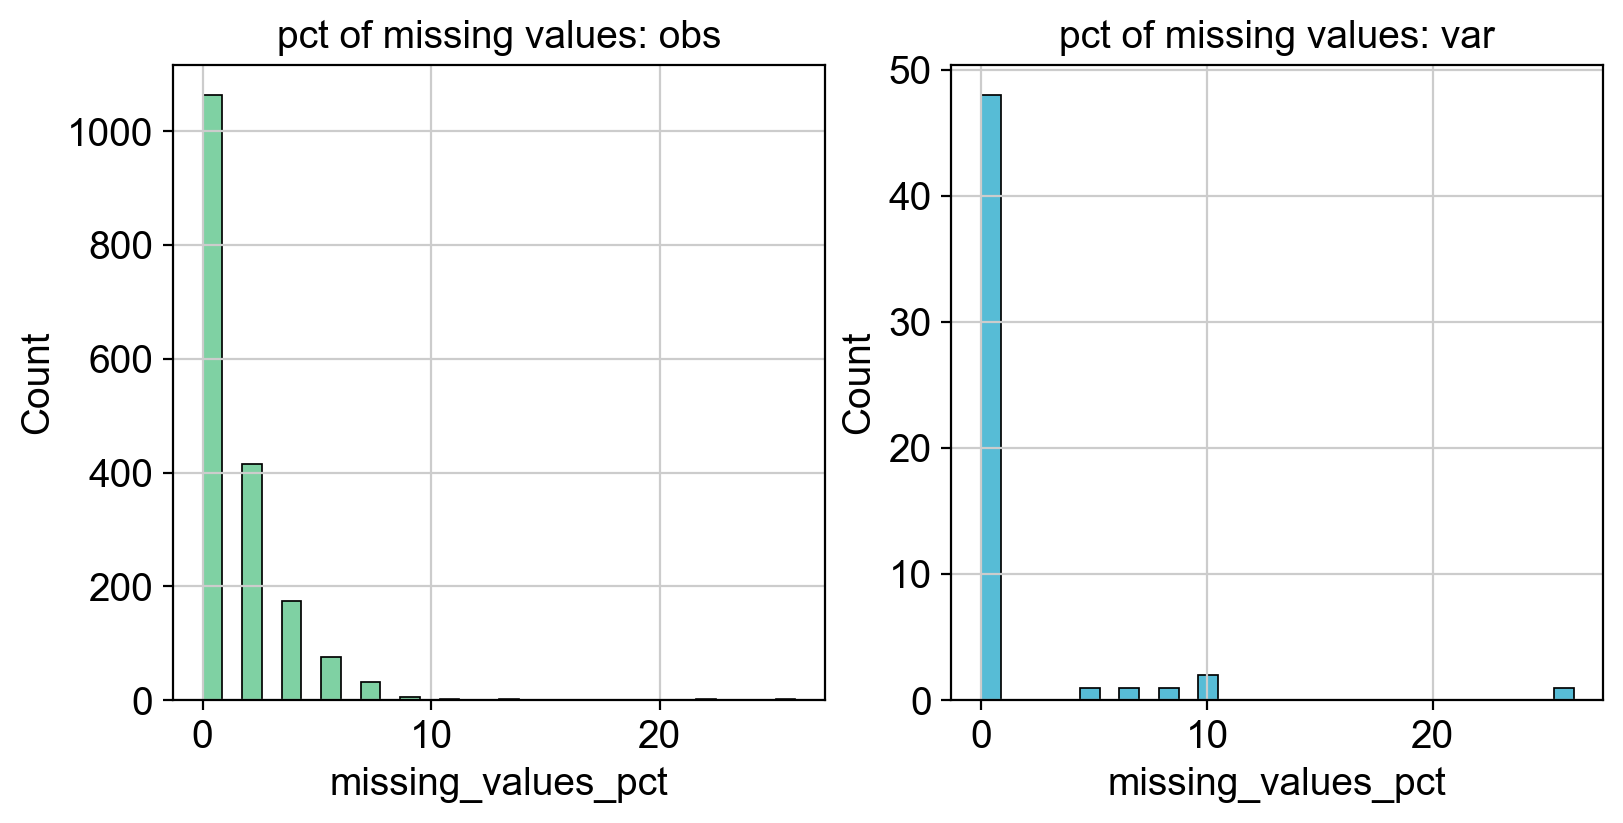

In [70]:
axd = plt.figure(constrained_layout=True, figsize=(8, 4), dpi=100).subplot_mosaic(
    """
    AB
    """
)

sns.histplot(
    adata.obs["missing_values_pct"], ax=axd["A"], bins=30, color="#54C285"
).set(title="pct of missing values: obs")
sns.histplot(
    adata.var["missing_values_pct"], ax=axd["B"], bins=30, color="#1FA6C9"
).set(title="pct of missing values: var")

We can also check which features have the highest percentage of missing values in both **obs** and **vars**.

In [71]:
adata.obs.loc[
    adata.obs["missing_values_pct"] == adata.obs["missing_values_pct"].max(), :
]

service_unit day_icu_intime  missing_values_abs  missing_values_pct
1732         SICU      Thursday                   14           25.925926
1751         MICU      Tuesday                    14           25.925926

In [72]:
adata.var.loc[
    adata.var["missing_values_pct"] == adata.var["missing_values_pct"].max(), :
]

feature_type unencoded_var_names encoding_mode  missing_values_abs  \
bmi      numeric                 bmi           NaN                 466   

     missing_values_pct       mean     median  standard_deviation        min  \
bmi           26.238739  27.827316  26.324846             8.20694  12.784877   

           max  iqr_outliers  
bmi  98.797134          True

Overall, the percentage of missing values in all features is rather low, however, still some features are not complete.

Features with missing values can introduce a bias in the data, making the processing and analysis challenging. To prevent loss of information due to dropping of multiple features, we can fill up the missing values by performing an imputation. Here, we infer the missing values based on the exisitng part of the data. 

To perform this efficiently, we suggest to drop features if the percentage of missing values is very high (>60%). In our data, there is no need to drop any feature, since none exceeds more than 27% missing values (BMI, vars).

#### Missing data imputation

ehrapy offers many options to [impute](https://ehrapy.readthedocs.io/en/latest/usage/usage.html#imputation) missing values in an AnnData object.
Here, we use KNN imputation with 5 neighbors (`n_neighbors=5`, the default value). The KNN algorithm uses proximity to predict the missing values of a feature by finding the `k` closest neighbors to the missing value and then imputing the missing value based on the non-missing values in the neighborhood.

In [73]:
ep.pp.knn_impute(adata, n_neighbours=5)

Output()

After recalcuating the QC metrices, we can check again the percentage of missing values.

In [74]:
ep.pp.qc_metrics(adata)

(      missing_values_abs  missing_values_pct
 0                      0                 0.0
 1                      0                 0.0
 2                      0                 0.0
 3                      0                 0.0
 4                      0                 0.0
 ...                  ...                 ...
 1771                   0                 0.0
 1772                   0                 0.0
 1773                   0                 0.0
 1774                   0                 0.0
 1775                   0                 0.0
 
 [1776 rows x 2 columns],
                                     missing_values_abs  missing_values_pct  \
 ehrapycat_service_unit_FICU                          0                 0.0   
 ehrapycat_service_unit_MICU                          0                 0.0   
 ehrapycat_service_unit_SICU                          0                 0.0   
 ehrapycat_day_icu_intime_Friday                      0                 0.0   
 ehrapycat_day_icu_intime

[Text(0.5, 1.0, 'pct of missing values: var'), (0.0, 30.0)]

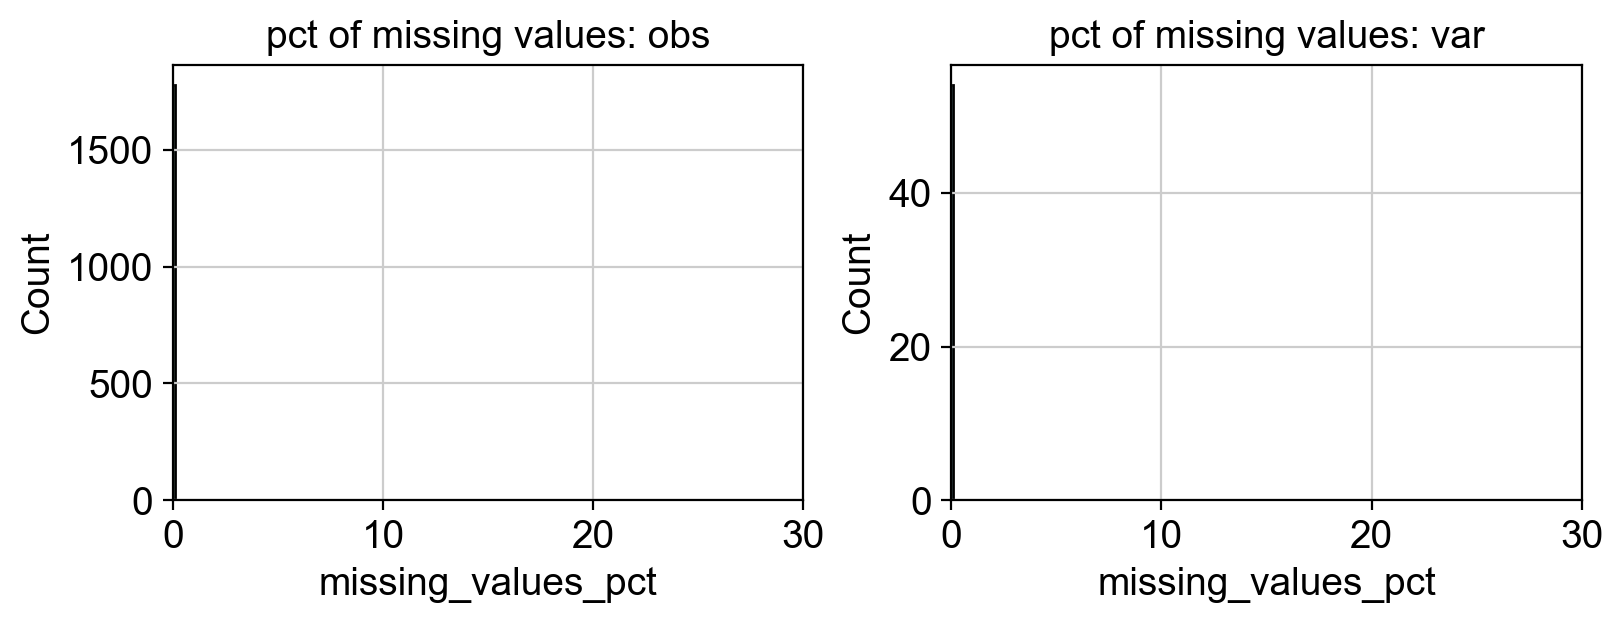

In [75]:
axd = plt.figure(constrained_layout=True, figsize=(8, 3), dpi=100).subplot_mosaic(
    """
    AB
    """
)

sns.histplot(adata.obs["missing_values_pct"], ax=axd["A"], bins=5, color="#54C285").set(
    title="pct of missing values: obs", xlim=(0, 30)
)
sns.histplot(adata.var["missing_values_pct"], ax=axd["B"], bins=5, color="#1FA6C9").set(
    title="pct of missing values: var", xlim=(0, 30)
)

#### Data distribution

Depending on the measurement and the unit of a measurement the value ranges of features may be huge.
Clusterings and differential comparisons especially may be greatly influenced by exceptionally big values. 

[Text(0.5, 1.0, 'maximum values')]

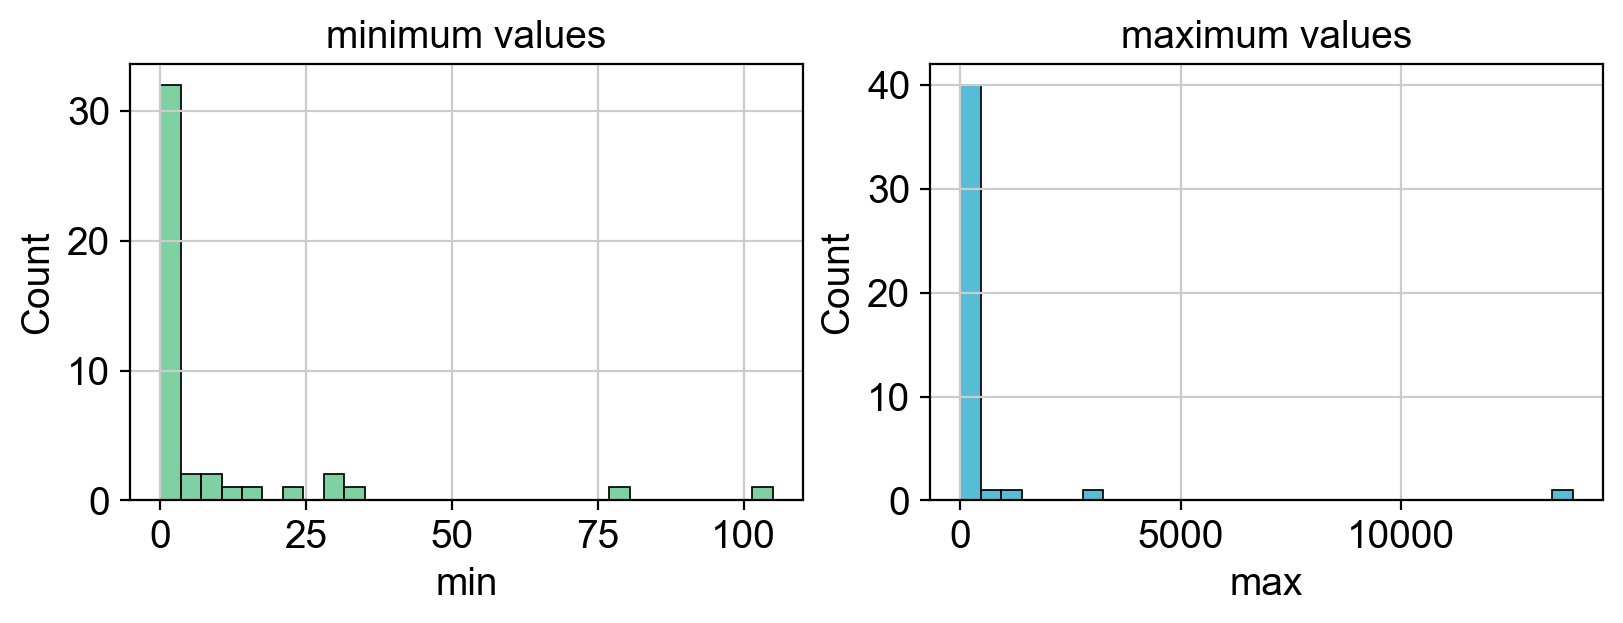

In [76]:
axd = plt.figure(constrained_layout=True, figsize=(8, 3), dpi=100).subplot_mosaic(
    """
    AB
    """
)

sns.histplot(adata.var["min"], ax=axd["A"], bins=30, color="#54C285").set(
    title="minimum values"
)
sns.histplot(adata.var["max"], ax=axd["B"], bins=30, color="#1FA6C9").set(
    title="maximum values"
)

Moreover, features which have a very high coefficient of variation can strongly influence dimensionality reduction. However, since the coefficient of variation performs weak with features that have small means, we only select those which have no small mean. 

In [77]:
adata.var["coefficient.variation"] = (
    adata.var["standard_deviation"] / adata.var["mean"]
) * 100

In [78]:
adata.var.loc[(adata.var["coefficient.variation"] > 50) & (adata.var["mean"] > 50),]

feature_type unencoded_var_names encoding_mode  \
mort_day_censored      numeric   mort_day_censored           NaN   
po2_first              numeric           po2_first           NaN   
iv_day_1               numeric            iv_day_1           NaN   

                   missing_values_abs  missing_values_pct         mean  \
mort_day_censored                   0                 0.0   614.329825   
po2_first                           0                 0.0   227.499346   
iv_day_1                            0                 0.0  1571.128035   

                        median  standard_deviation   min           max  \
mort_day_censored   731.000000          402.996046   0.0   3094.080078   
po2_first           200.040001          138.524999  22.0    634.000000   
iv_day_1           1027.599976         1624.982216   0.0  13910.000000   

                   iqr_outliers  coefficient.variation  
mort_day_censored          True              65.599297  
po2_first                  True              60.890285  
iv_day_1                   True             103.427740

The standard deviations and coefficients of variation of the features **iv_day_1** (input fluids by IV on day 1 in mL) and **po2_first** (first PaO_2 in mmHg) are very high with strong spread between minimum and maximum values. These features require normalization. 

### Normalization

ehrapy offers several options to [normalize](https://ehrapy.readthedocs.io/en/latest/usage/usage.html#normalization) data. While it is possible to normalize all numerical values at once with the same normalization function, normalizing only the features with high spread, here **iv_day_1** and **po2_first**, can be sufficient.
Log normalization with an offset of 1 to add pseudocounts seems appropriate.

Note: When features with negative values should be normalized you have to use the *pp.offset_negative_values()* function prior normalization.

In [79]:
ep.pp.log_norm(adata, vars=["iv_day_1", "po2_first"], offset=1)

AnnData object with n_obs × n_vars = 1776 × 54
    obs: 'service_unit', 'day_icu_intime', 'missing_values_abs', 'missing_values_pct'
    var: 'feature_type', 'unencoded_var_names', 'encoding_mode', 'missing_values_abs', 'missing_values_pct', 'mean', 'median', 'standard_deviation', 'min', 'max', 'iqr_outliers', 'coefficient.variation'
    uns: 'service_unit_colors', 'normalization'
    layers: 'original', 'raw_norm'

after normalization we can calculate the QC metrices again and check the distribution. 

In [80]:
ep.pp.qc_metrics(adata)

(      missing_values_abs  missing_values_pct
 0                      0                 0.0
 1                      0                 0.0
 2                      0                 0.0
 3                      0                 0.0
 4                      0                 0.0
 ...                  ...                 ...
 1771                   0                 0.0
 1772                   0                 0.0
 1773                   0                 0.0
 1774                   0                 0.0
 1775                   0                 0.0
 
 [1776 rows x 2 columns],
                                     missing_values_abs  missing_values_pct  \
 ehrapycat_service_unit_FICU                          0                 0.0   
 ehrapycat_service_unit_MICU                          0                 0.0   
 ehrapycat_service_unit_SICU                          0                 0.0   
 ehrapycat_day_icu_intime_Friday                      0                 0.0   
 ehrapycat_day_icu_intime

In [81]:
adata.var["coefficient.variation"] = (
    adata.var["standard_deviation"] / adata.var["mean"]
) * 100
adata.var.loc[(adata.var["coefficient.variation"] > 50) & (adata.var["mean"] > 50),]

feature_type unencoded_var_names encoding_mode  \
mort_day_censored      numeric   mort_day_censored           NaN   

                   missing_values_abs  missing_values_pct        mean  median  \
mort_day_censored                   0                 0.0  614.329825   731.0   

                   standard_deviation  min          max  iqr_outliers  \
mort_day_censored          402.996046  0.0  3094.080078          True   

                   coefficient.variation  
mort_day_censored              65.599297

The strong spread of **iv_day_1** and **po2_first** was succesfully removed. Now that we normalized the influence of these features, we can continue with dimensionality reduction. 

Dimensionality reduction reduces the number of features (dimensions) by projecting the data to a lower dimensional latent space retaining as much information as possible. This is very useful for high dimensional data, since it reduces complexity and facilitates visualization.

### Dimensionality reduction

#### Principle Component Analysis (PCA)

As a next step, we reduce the dimensionality of the dataset with [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).
We can also visualize the principal components with ehrapy using the `components` argument.

In [82]:
ep.pp.pca(adata)

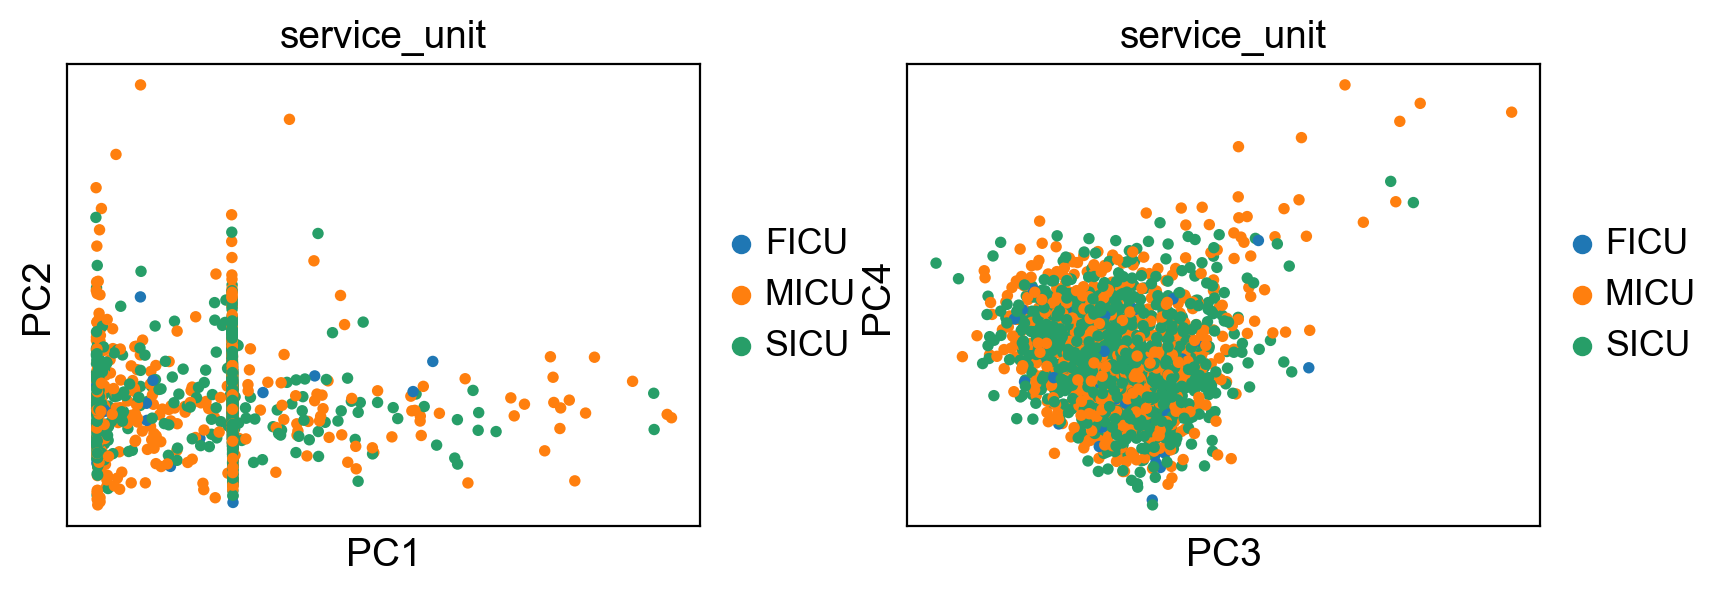

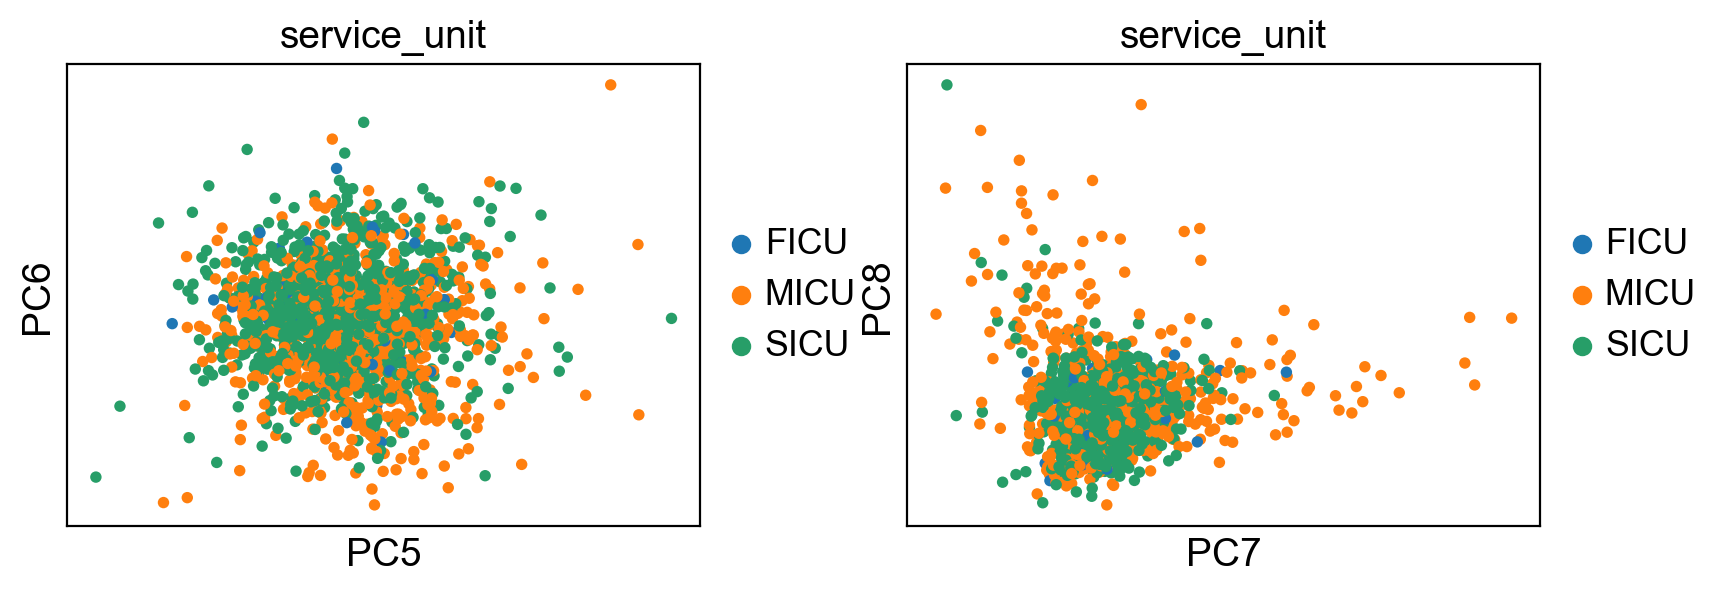

In [83]:
ep.pl.pca(adata, color="service_unit", components=["1,2", "3,4"])
ep.pl.pca(adata, color="service_unit", components=["5,6", "7,8"])

To inspect certain PCs further, we can inspect the PC dimensionality loadings which highlight the features that contribute strongest to the selected PC.

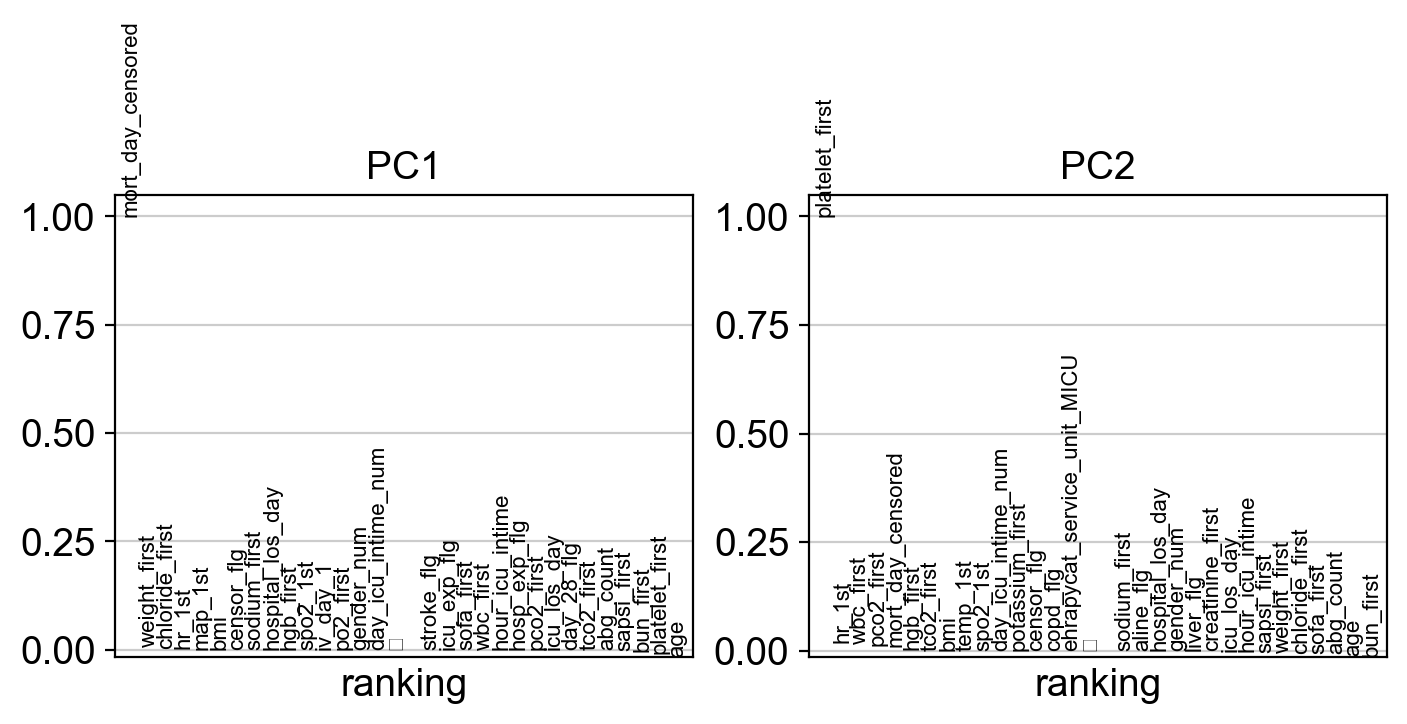

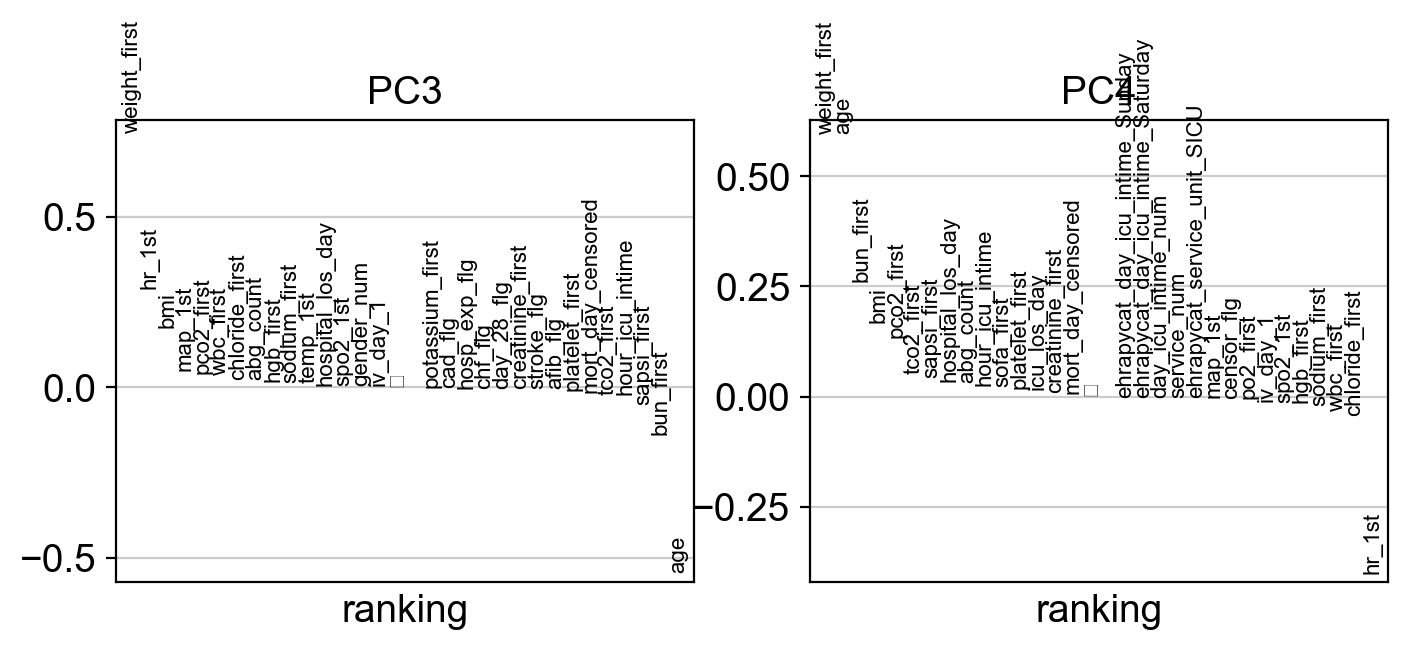

In [84]:
ep.pl.pca_loadings(adata, components="1, 2")
ep.pl.pca_loadings(adata, components="3, 4")

#### Uniform Manifold Approximation and Projection (UMAP) 

The reduced representation can then be used as input for the neighbors graph calculation which serves as the input for advanced embeddings and visualizations like [Uniform Manifold Approximation and Projection (UMAP) ](https://umap-learn.readthedocs.io/en/latest/)

In [85]:
ep.pp.neighbors(adata, n_pcs=10)

In [86]:
ep.tl.umap(adata)

### Checking for Batch effects

Before exploring the data further, we need to see if we have a batch effect. A batch effect can e.g. arise from different collection units or collection days. To check if our data contains a batch for those feautures, we visualize the `service_unit` and the `day_icu_intime`.


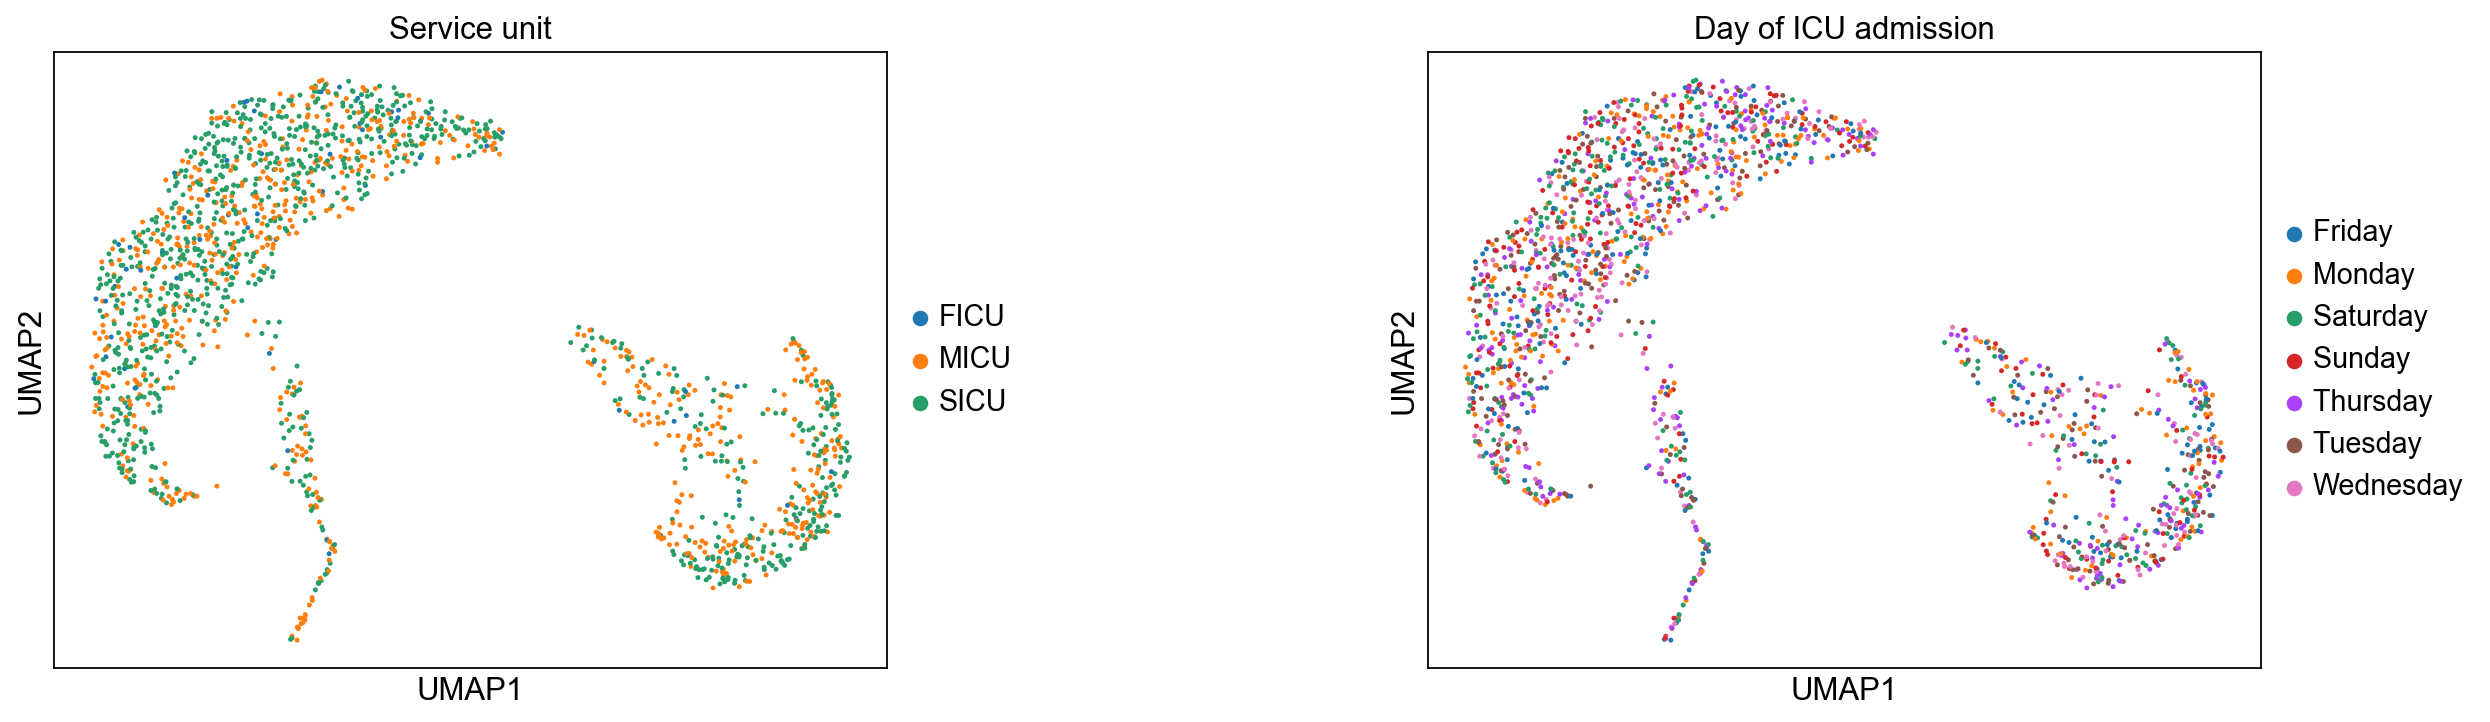

In [87]:
ep.settings.set_figure_params(figsize=(6, 5))
ep.pl.umap(
    adata,
    color=[
        "service_unit",
        "day_icu_intime",
    ],
    wspace=0.5,
    size=20,
    title=["Service unit", "Day of ICU admission"],
)

The embeddings suggest that there's no strong effect by the aforementioned potential confounders.

### Selected features on UMAP

Now we can also highlight other relevant features on the UMAP. Interesting features could be demographics, hospital statistics and lab parameters.

#### Demographics

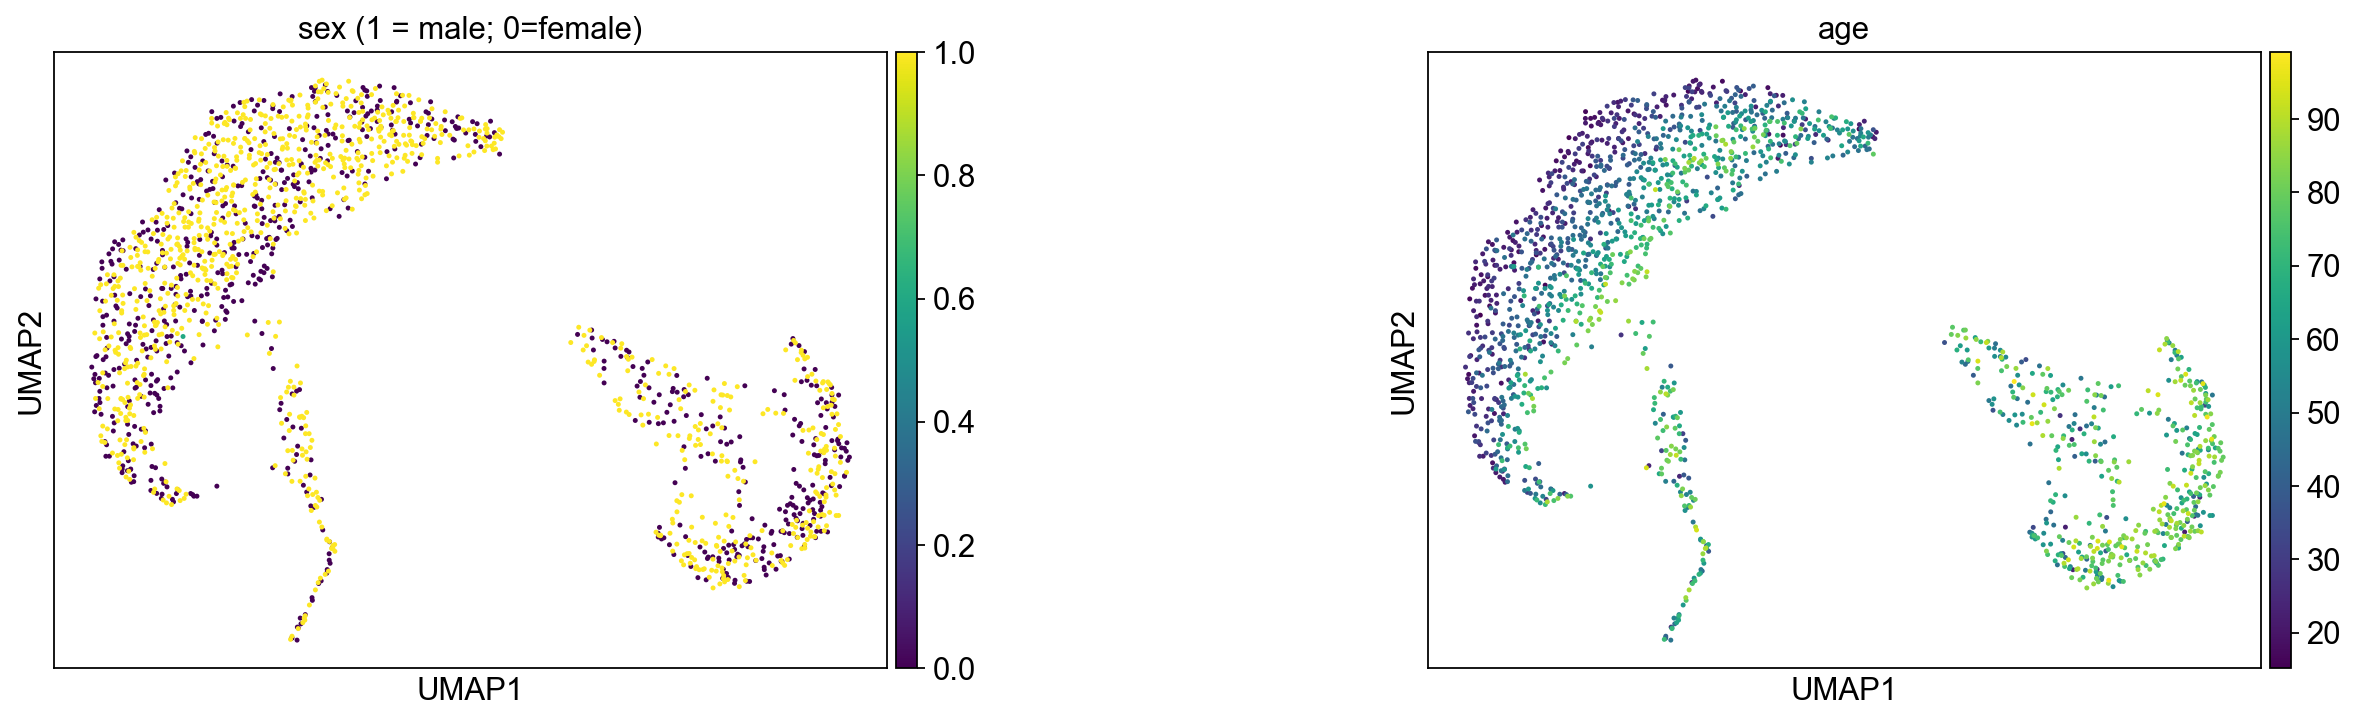

In [88]:
ep.pl.umap(
    adata,
    color=["gender_num", "age"],
    wspace=0.5,
    size=20,
    title=["sex (1 = male; 0=female)", "age"],
)

#### Hospital statistics

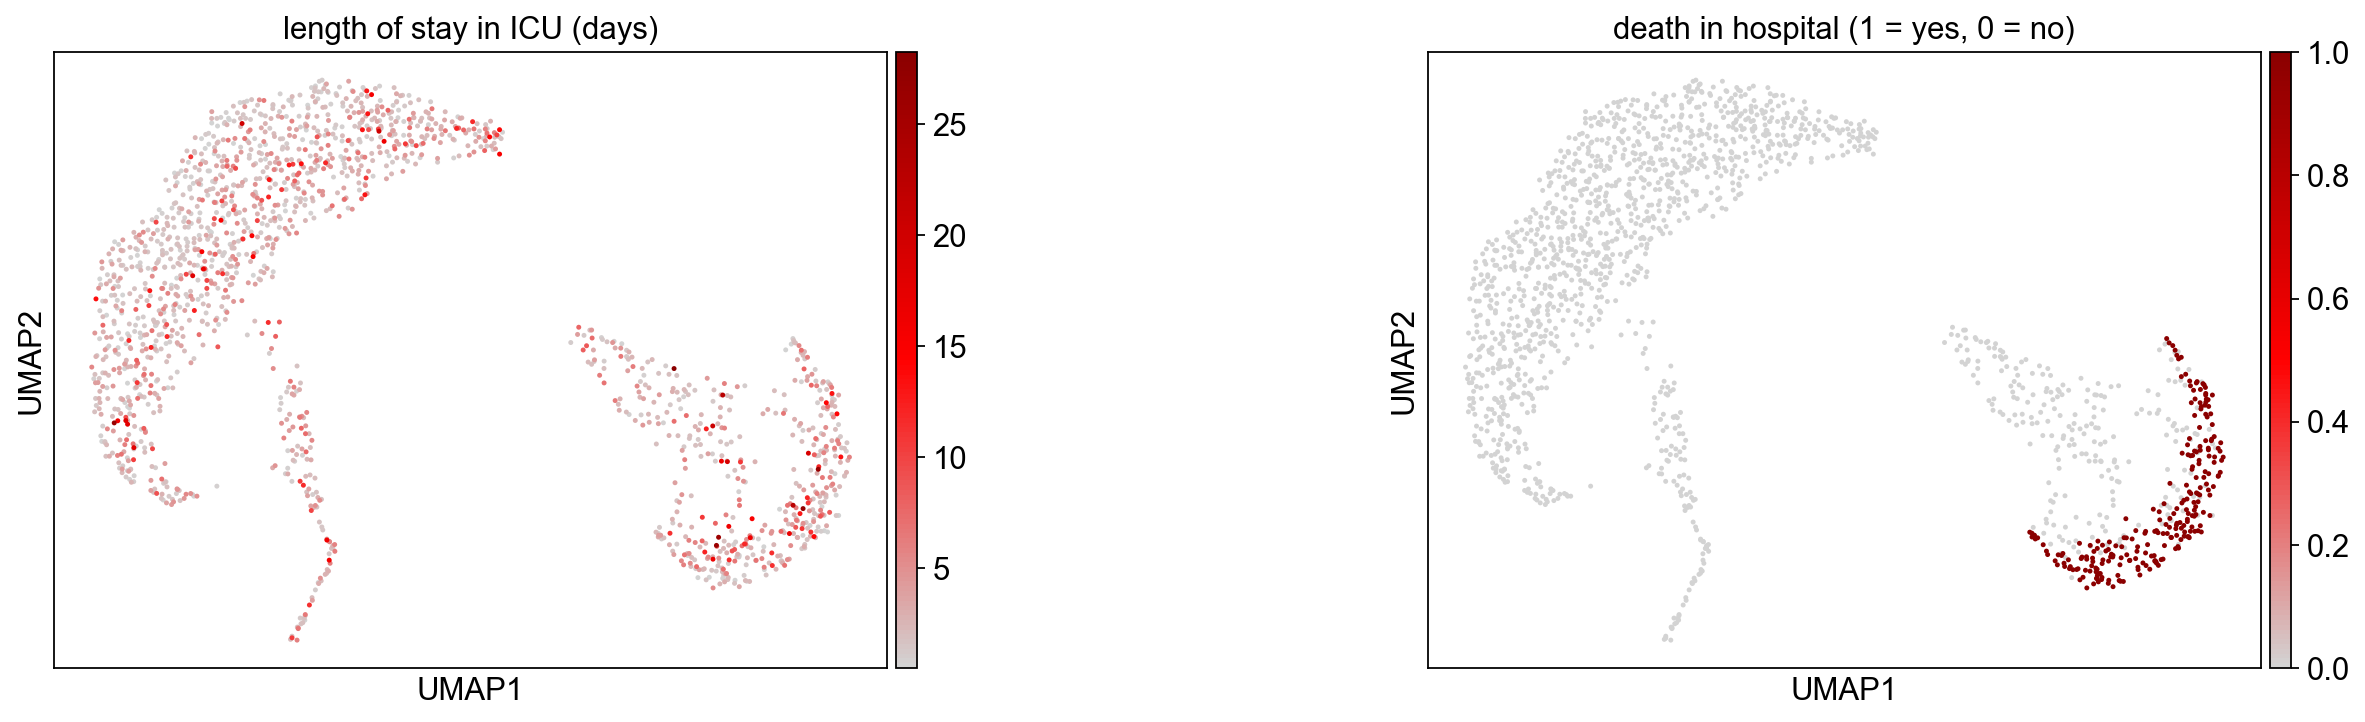

In [89]:
ep.pl.umap(
    adata,
    color=["icu_los_day", "hosp_exp_flg"],
    wspace=0.5,
    size=20,
    cmap=ep.pl.Colormaps.grey_red.value,
    title=["length of stay in ICU (days)", "death in hospital (1 = yes, 0 = no)"],
)

#### Comorbidities

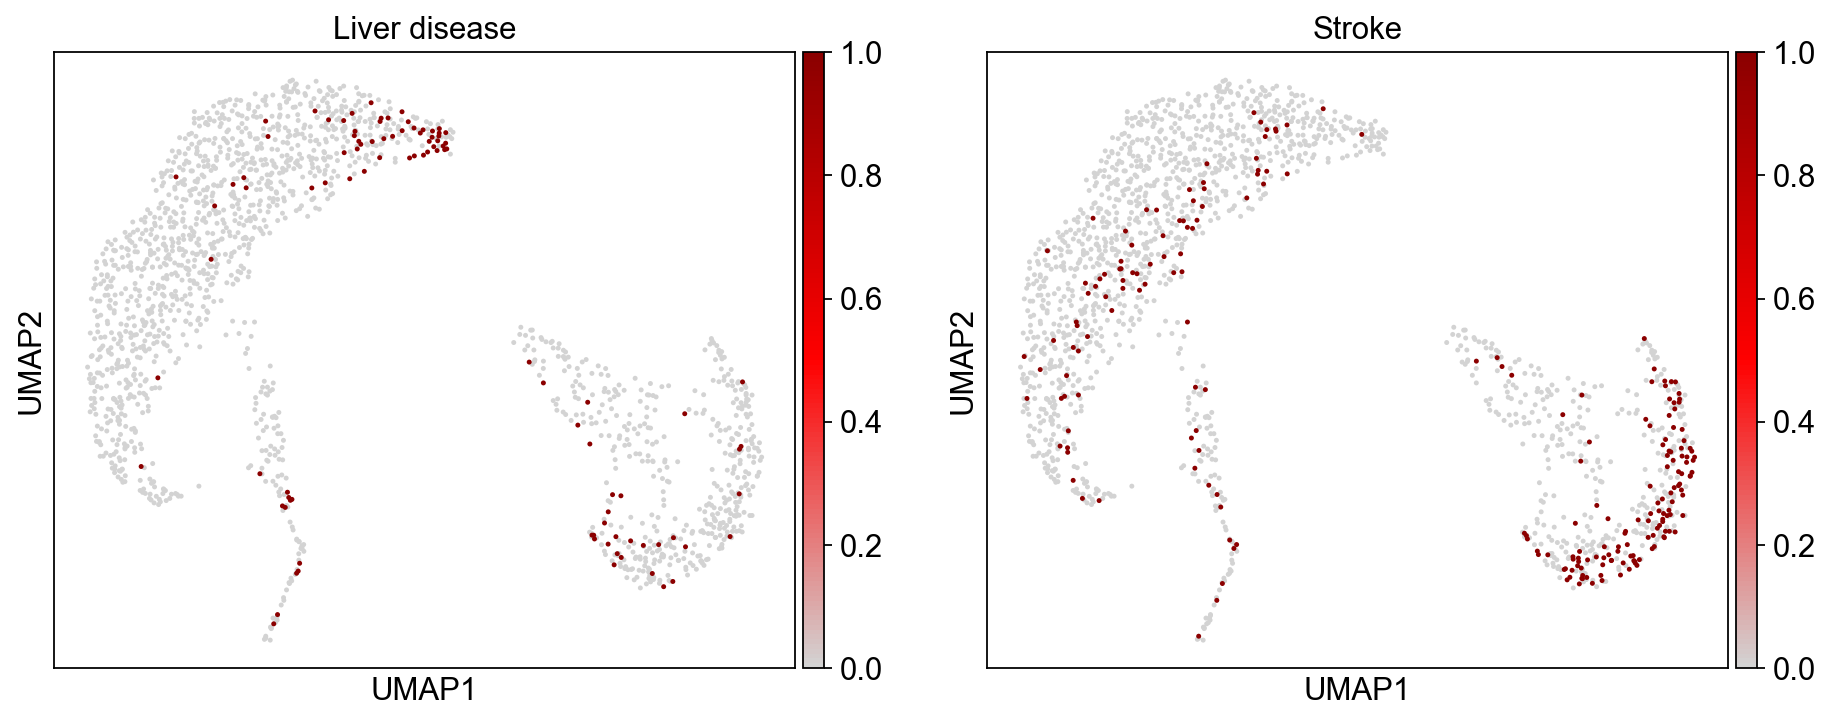

In [90]:
ep.pl.umap(
    adata,
    color=["liver_flg", "stroke_flg"],
    cmap=ep.pl.Colormaps.grey_red.value,
    title=["Liver disease", "Stroke"],
    ncols=2,
    size=20,
)

#### Lab parameters

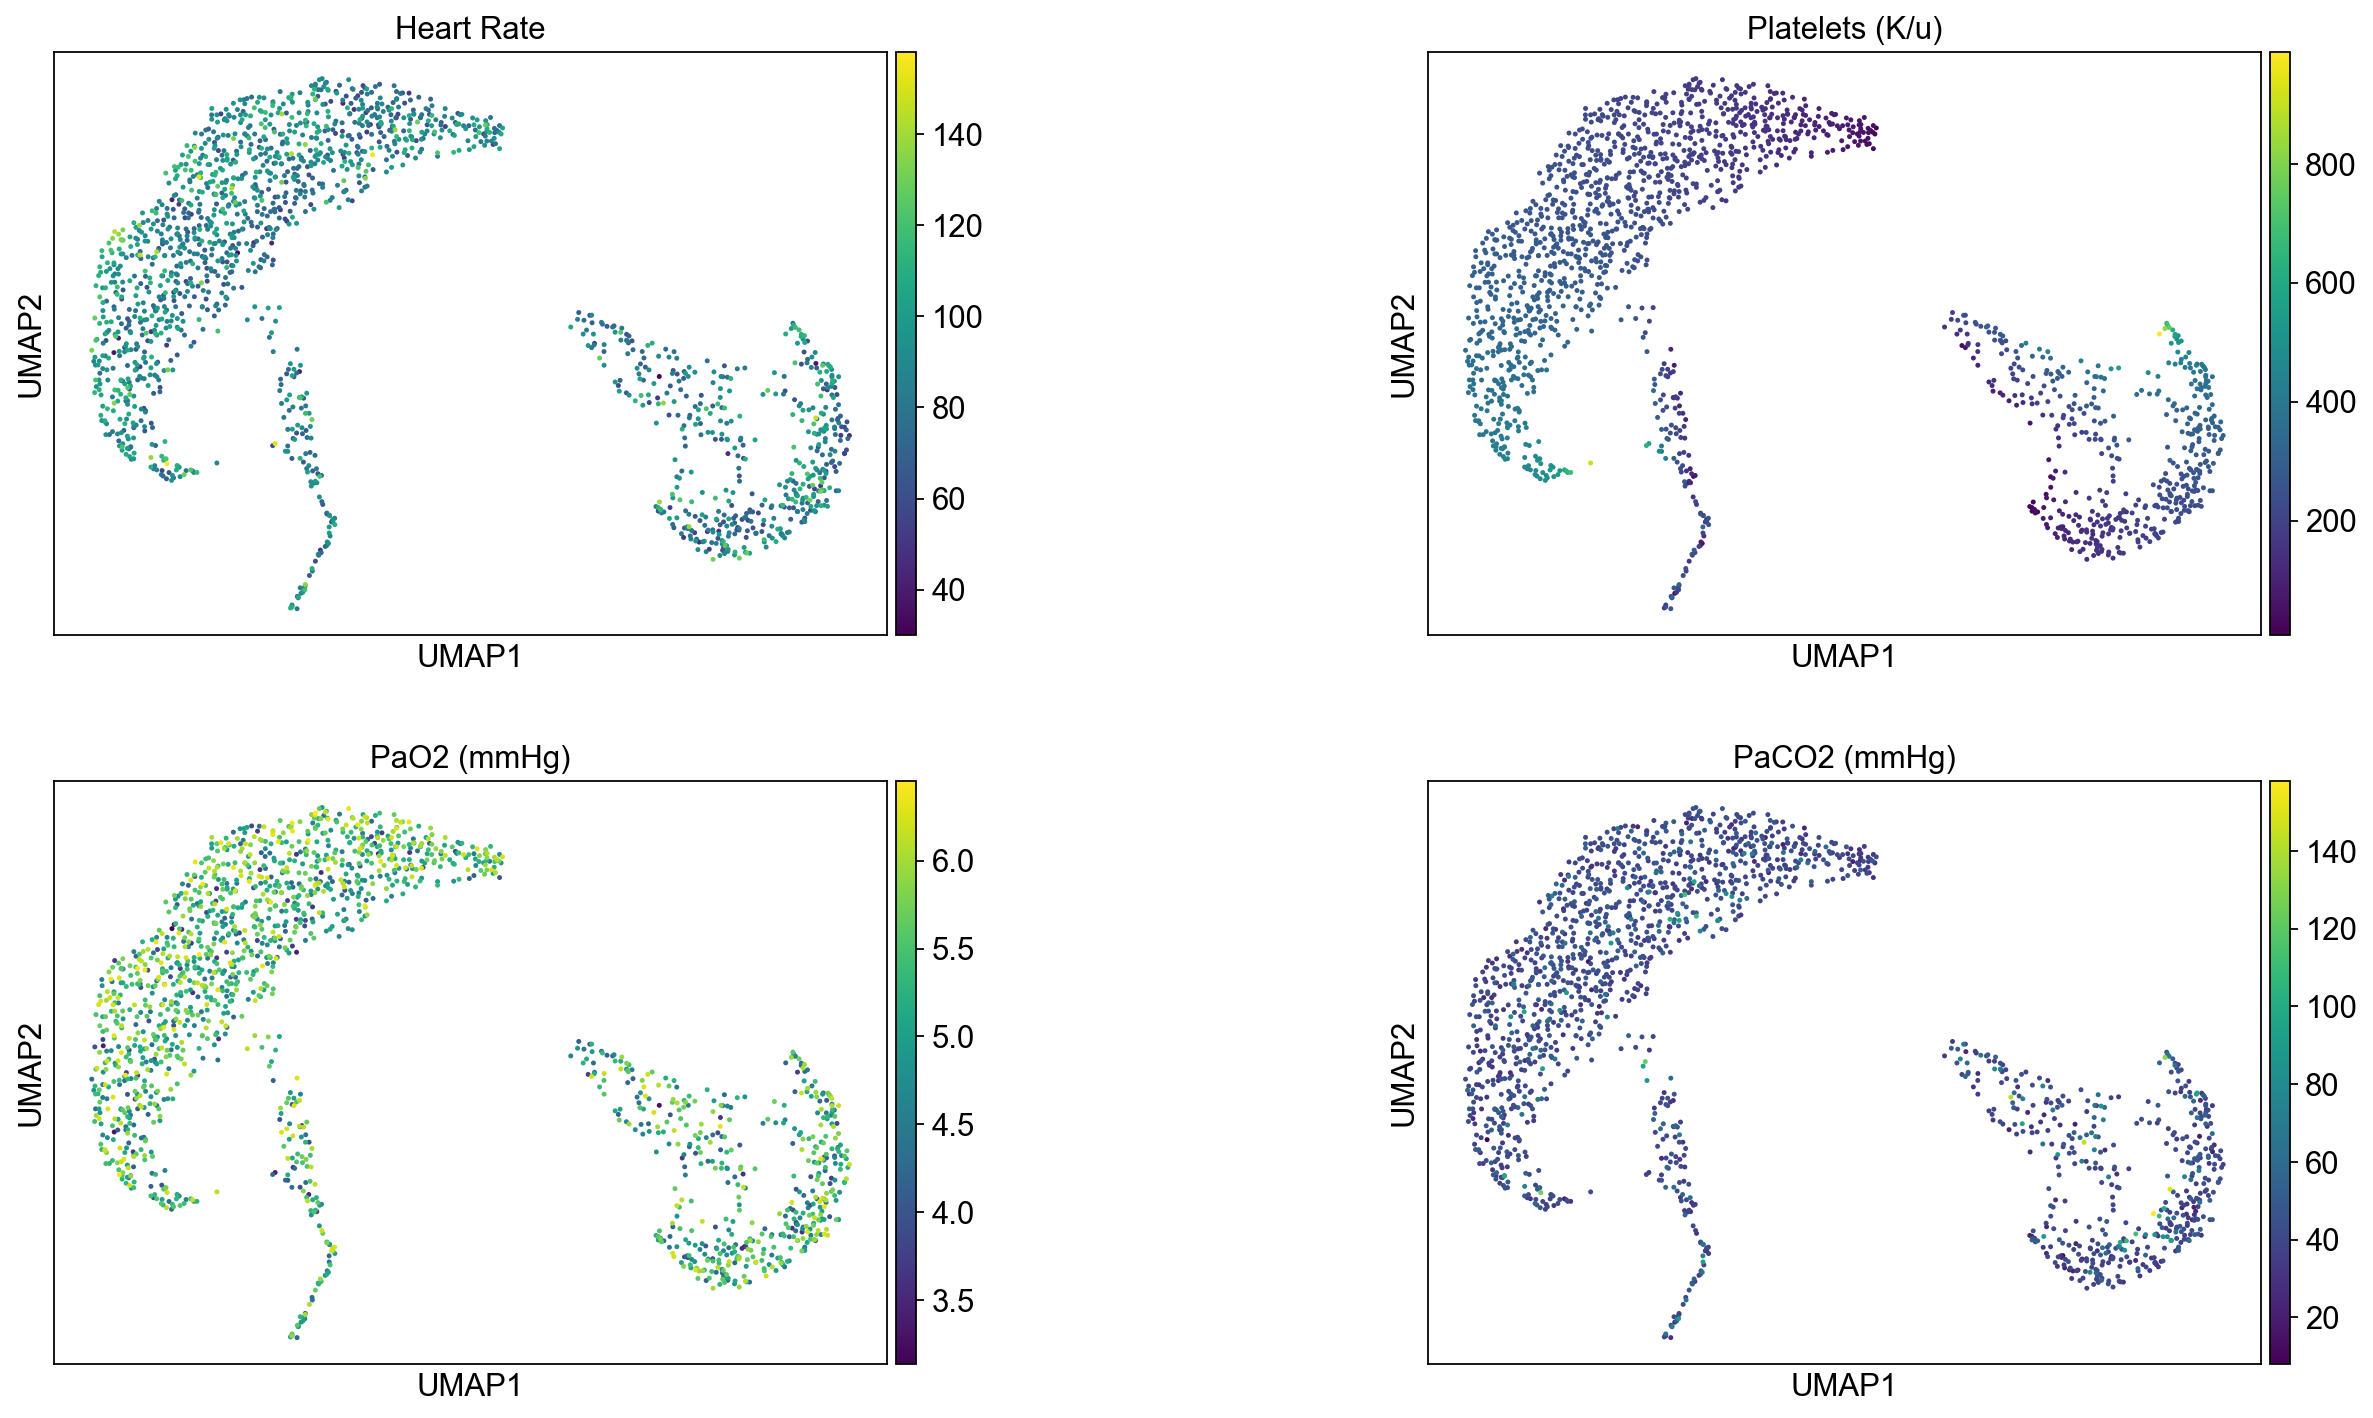

In [91]:
ep.pl.umap(
    adata,
    color=["hr_1st", "platelet_first", "po2_first", "pco2_first"],
    wspace=0.5,
    ncols=2,
    size=20,
    title=["Heart Rate", "Platelets (K/u)", "PaO2 (mmHg)", "PaCO2 (mmHg)"],
)

### Cluster analysis

To make more sense of the embedding it is often times useful to determine clusters through e.g. community detection as implemented in the [Leiden algorithm](https://www.nature.com/articles/s41598-019-41695-z). Moreover, clustering allows for unbiased detection of features that are changed between clusters and therefore intersting for us.  

#### Cluster identification

The implementation in ehrapy allows for the setting of a resolution which determines the number of found clusters. It is often times useful to play around with the parameter.

In [92]:
ep.tl.leiden(adata, resolution=0.3, key_added="leiden_0_3")

The leiden algorithm added a key to **obs** (`leiden_0_3`) that stores the clusters. These can subsequently be visualized in the UMAP embedding.

In [93]:
adata.obs.head(4)

service_unit day_icu_intime  missing_values_abs  missing_values_pct  \
0         SICU      Friday                      0                 0.0   
1         MICU      Saturday                    0                 0.0   
2         MICU      Friday                      0                 0.0   
3         SICU      Saturday                    0                 0.0   

  leiden_0_3  
0          1  
1          0  
2          3  
3          1

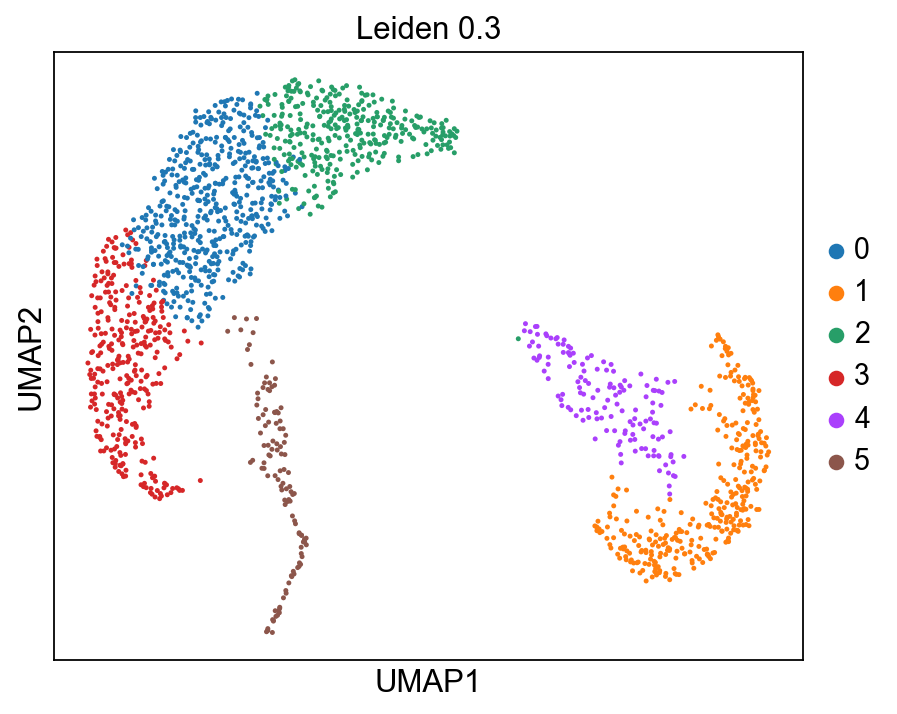

In [94]:
ep.pl.umap(adata, color=["leiden_0_3"], title="Leiden 0.3", size=20)

Next, we can explore certain features which are special for certrain clusters and could therefore be used for annotation.

#### Cluster features

In [95]:
ep.tl.rank_features_groups(adata, groupby="leiden_0_3")

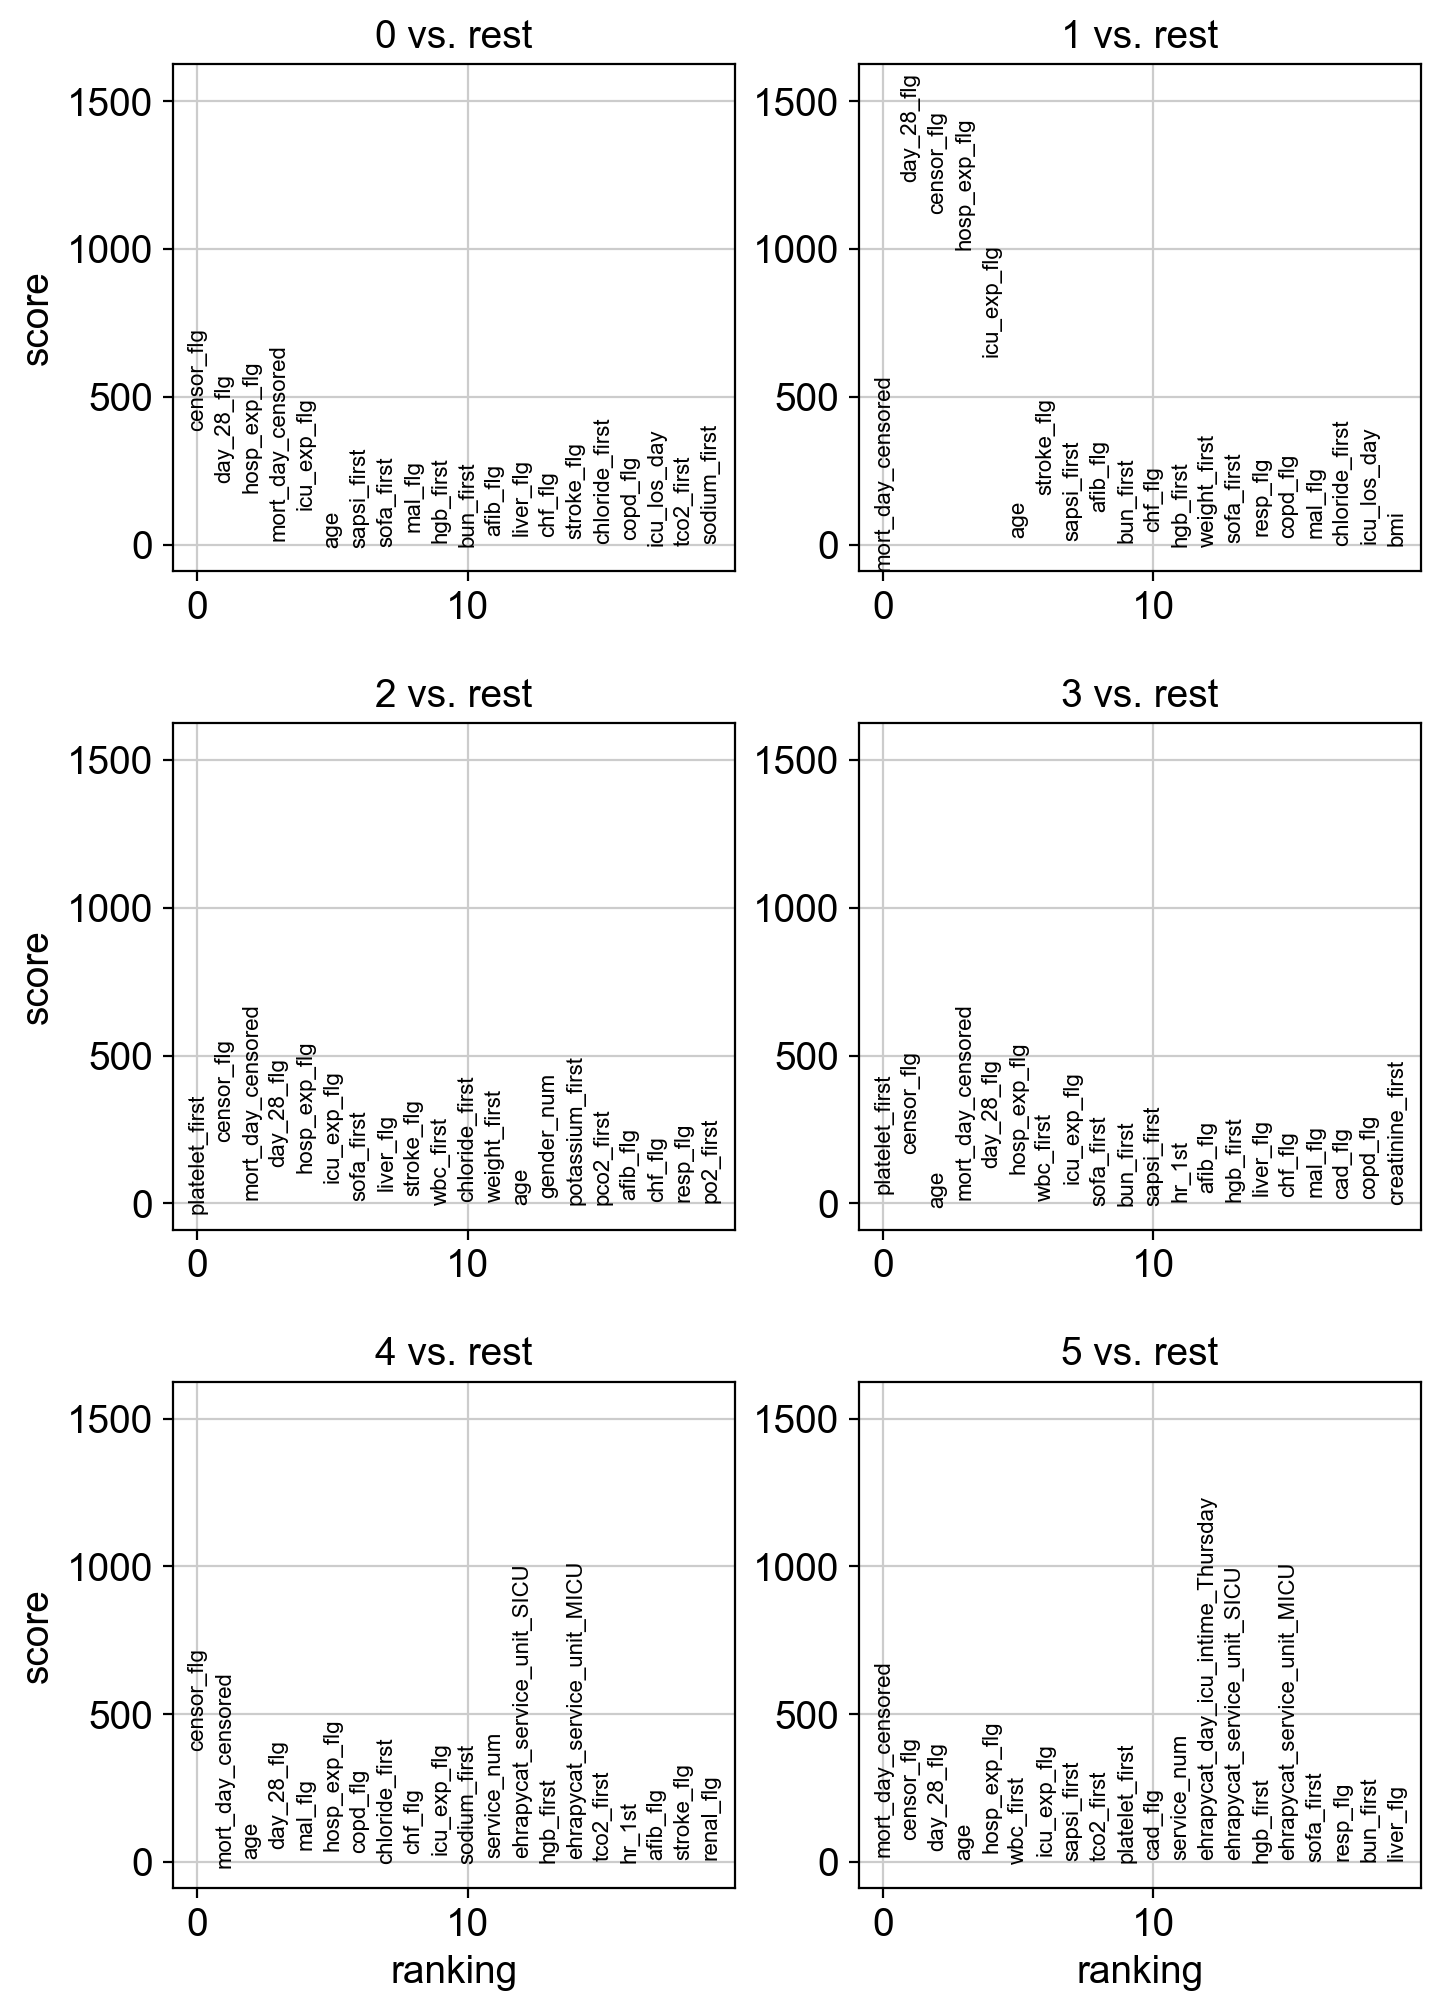

In [96]:
ep.settings.set_figure_params(figsize=(4, 4), dpi=100)
ep.pl.rank_features_groups(adata, key="rank_features_groups", ncols=2)

We can also get the top features per cluster as a DataFrame.

In [97]:
df = ep.ad.get_rank_features_df(adata, group=["0", "1", "2", "3", "4", "5"])
df = df.loc[(df["logfoldchanges"] > 0) & (df["pvals_adj"] < 0.05),]

E.g. we can check the top marker of cluster 2.

In [98]:
df.loc[df["group"] == "2",]

group                        names      scores  logfoldchanges  \
109     2                   censor_flg  207.881020        1.000000   
110     2            mort_day_censored   12.332548             inf   
111     2                   day_28_flg  124.567350        1.000000   
112     2                 hosp_exp_flg  105.152346        1.000000   
113     2                  icu_exp_flg   69.899425        1.000000   
114     2                   sofa_first    7.506701        1.623888   
115     2                    liver_flg   43.055328        1.000000   
116     2                   stroke_flg   26.290865        1.000000   
118     2               chloride_first    4.767494        2.487876   
119     2                 weight_first    4.470621        9.405868   
121     2                   gender_num   19.266426        1.000000   
124     2                     afib_flg   11.124937        1.000000   
125     2                      chf_flg    7.238979        1.000000   
126     2                     resp_flg    7.248672        1.000000   
127     2                    po2_first    2.615415        0.151288   
128     2  ehrapycat_service_unit_MICU    6.132956        1.000000   
129     2                    aline_flg    6.200061        1.000000   

            pvals     pvals_adj  
109  3.982706e-47  1.075330e-45  
110  2.671621e-33  4.808918e-32  
111  6.329400e-29  8.544689e-28  
112  1.130974e-24  1.221452e-23  
113  6.240663e-17  5.616597e-16  
114  3.115968e-13  2.403747e-12  
115  5.321350e-11  3.591911e-10  
116  2.936745e-07  1.762047e-06  
118  2.480180e-06  1.217543e-05  
119  9.859004e-06  4.436552e-05  
121  6.551620e-05  2.527053e-04  
124  8.517477e-04  2.705551e-03  
125  7.133752e-03  2.027487e-02  
126  7.095347e-03  2.027487e-02  
127  9.169249e-03  2.475697e-02  
128  1.326848e-02  3.256809e-02  
129  1.277459e-02  3.256809e-02

From this table we can also extract the top features in every cluster and highlight those either on the UMAP or as violins plots by cluster.

In [99]:
top_features = df.groupby("group").head(5)
top_features = pd.Series(top_features["names"].unique())
top_features

0           censor_flg
1           day_28_flg
2         hosp_exp_flg
3    mort_day_censored
4          icu_exp_flg
5                  age
6       platelet_first
7              mal_flg
dtype: object

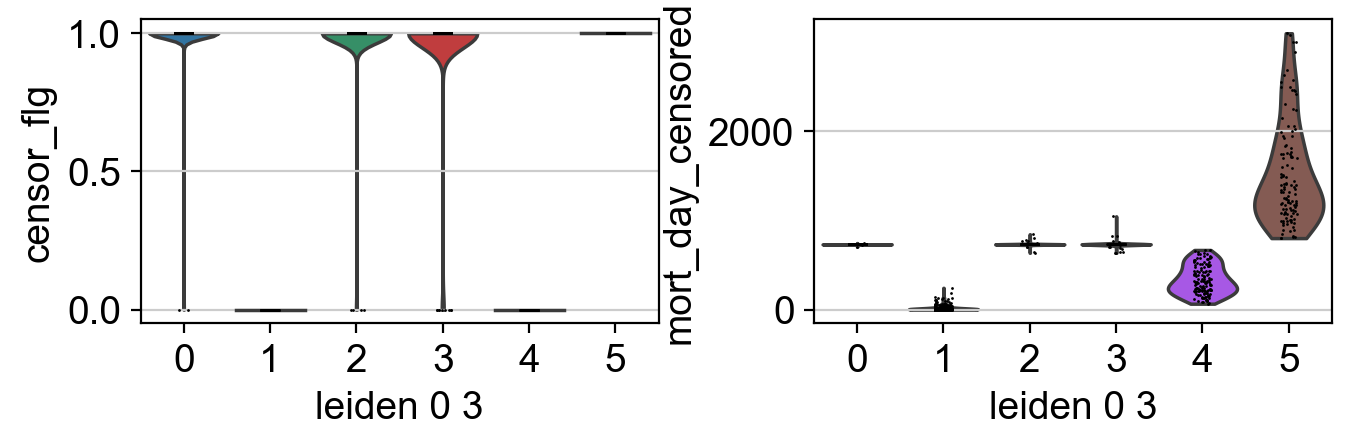

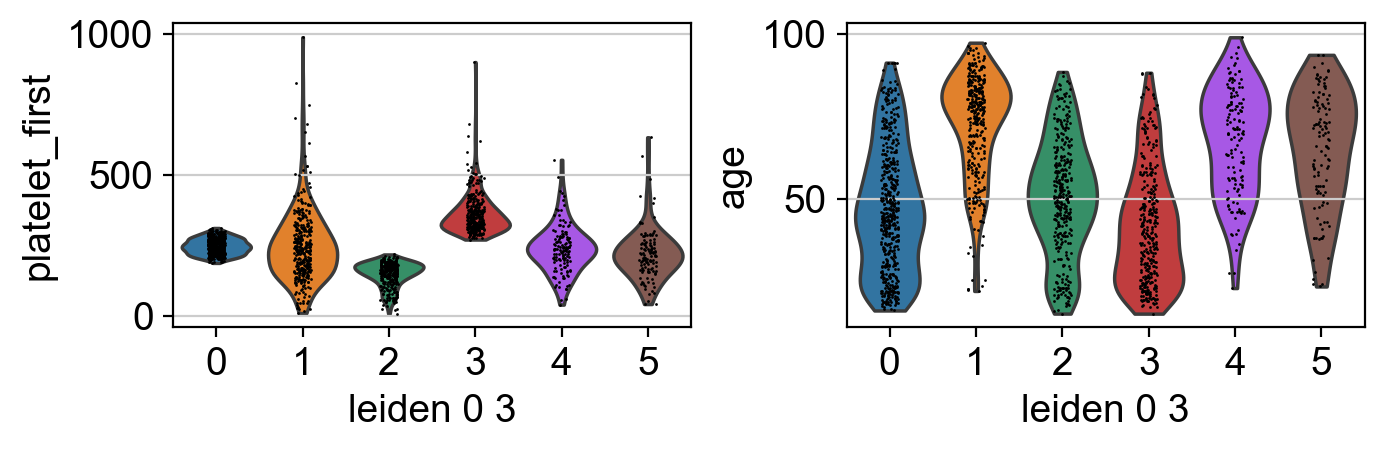

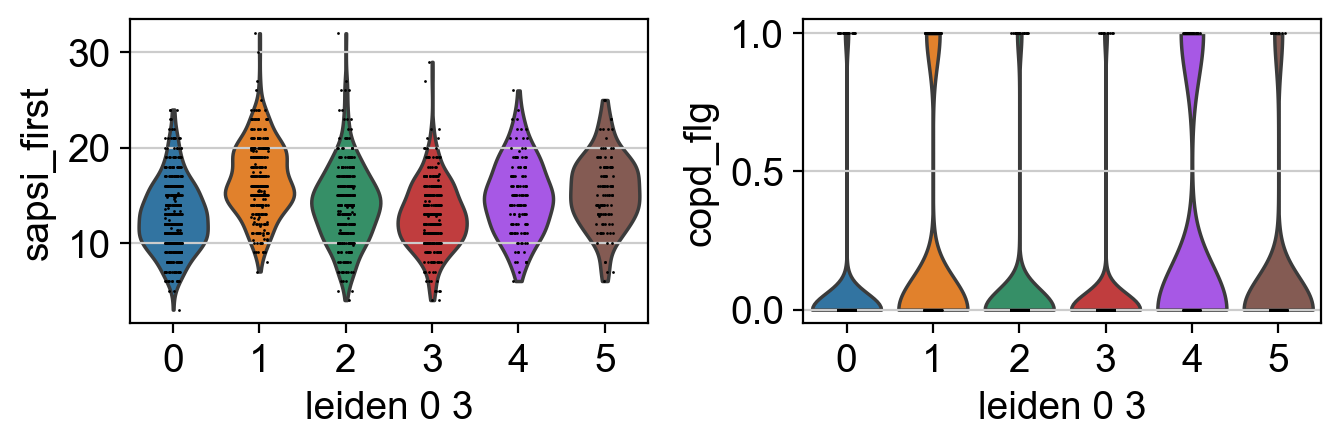

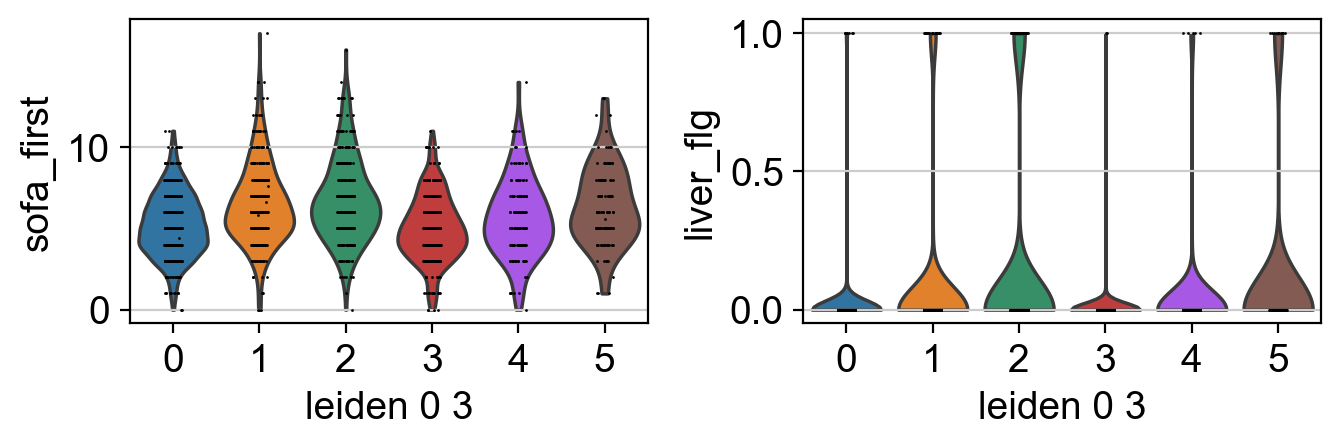

In [100]:
ep.settings.set_figure_params(figsize=(3.8, 2), dpi=100)
ep.pl.violin(adata, keys=["censor_flg", "mort_day_censored"], groupby="leiden_0_3")
ep.pl.violin(adata, keys=["platelet_first", "age"], groupby="leiden_0_3")
ep.pl.violin(adata, keys=["sapsi_first", "copd_flg"], groupby="leiden_0_3")
ep.pl.violin(adata, keys=["sofa_first", "liver_flg"], groupby="leiden_0_3")

#### Cluster annotation

With the knowledge of the cluster features, together with the UMAP plots from above we can annotate the clusters.

In [101]:
adata.obs["annotation"] = "NA"

In [102]:
annotation = {
    "0": "liver+/sofa+",
    "1": "weight+",
    "2": "age+/stroke+/deceased+",
    "3": "platelet+",
    "4": "age+/malignancy+/copd+/deceased+",
    "5": "age+",
}

In [103]:
adata.obs["annotation"] = [
    annotation[l] if l in annotation.keys() else l for l in adata.obs["leiden_0_3"]
]

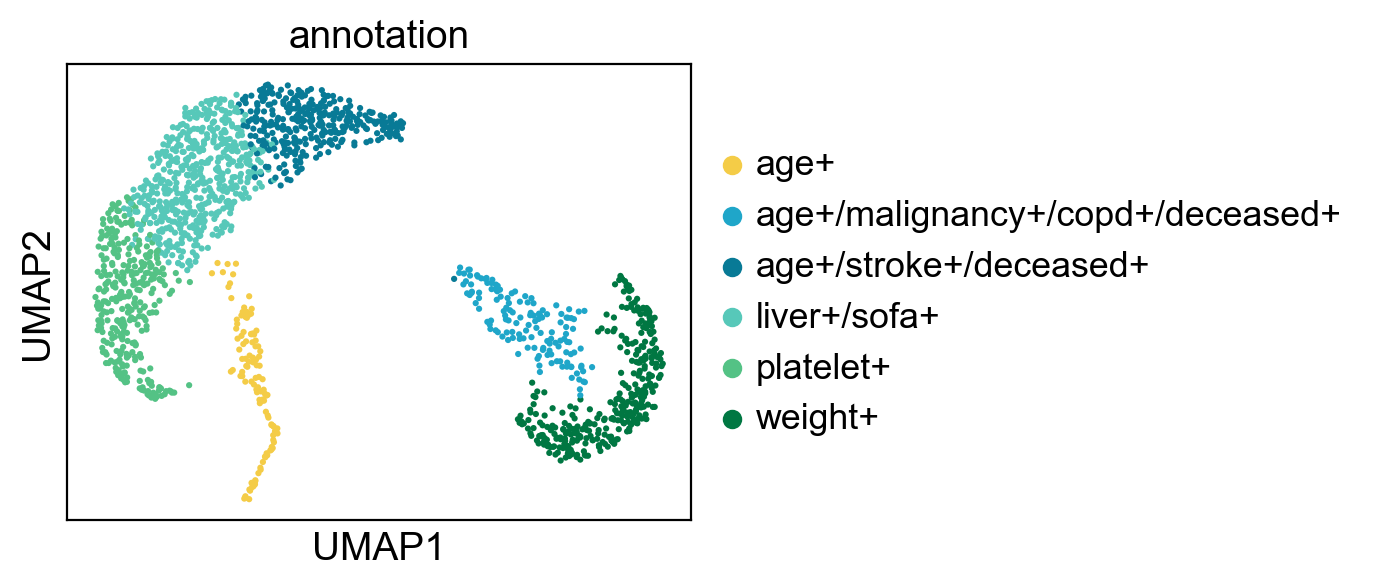

In [104]:
ep.settings.set_figure_params(figsize=(4, 3), dpi=100)
ep.pl.umap(
    adata,
    color="annotation",
    size=20,
    palette={
        "weight+": "#007742",
        "platelet+": "#54C285",
        "age+/stroke+/deceased+": "#087A96",
        "age+/malignancy+/copd+/deceased+": "#1FA6C9",
        "age+": "#F4CC47",
        "liver+/sofa+": "#57C8B9",
        "platelet+/heart_rate+": "#ABEC7D",
    },
)

### Additional downstream analysis 

After these basic ehrapy analysis steps, additional downstream analysis can be performed (see also other tutorials). 

#### PAGA

It might also be of interest to infer trajectories to learn about dynamic processes and stage transitions.
ehrapy offers several [trajectory inference](https://ehrapy.readthedocs.io/en/latest/usage/usage.html#clustering-and-trajectory-inference) algorithms for this purpose. One of those is partition-based graph abstraction (PAGA).

In [105]:
ep.tl.paga(adata, groups="leiden_0_3")

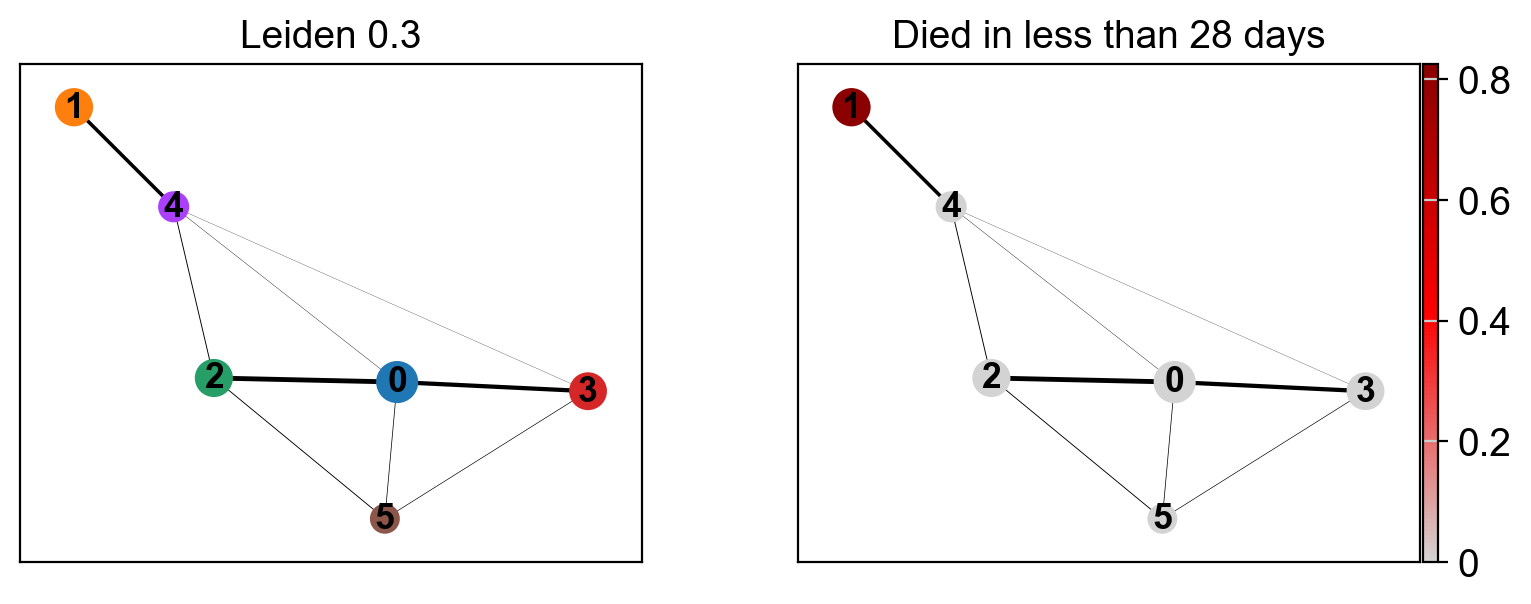

In [106]:
ep.pl.paga(
    adata,
    color=["leiden_0_3", "day_28_flg"],
    cmap=ep.pl.Colormaps.grey_red.value,
    title=["Leiden 0.3", "Died in less than 28 days"],
)

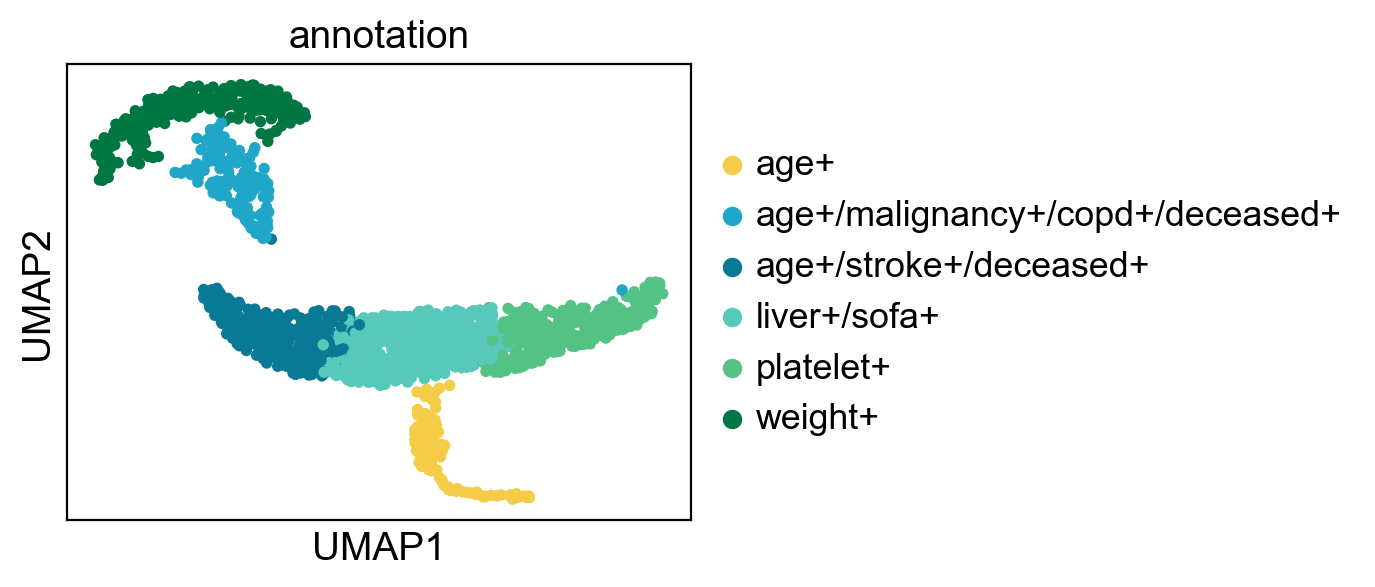

In [107]:
ep.tl.umap(adata, init_pos="paga")
ep.pl.umap(adata, color=["annotation"])

In [108]:
ep.tl.draw_graph(adata, init_pos="paga")

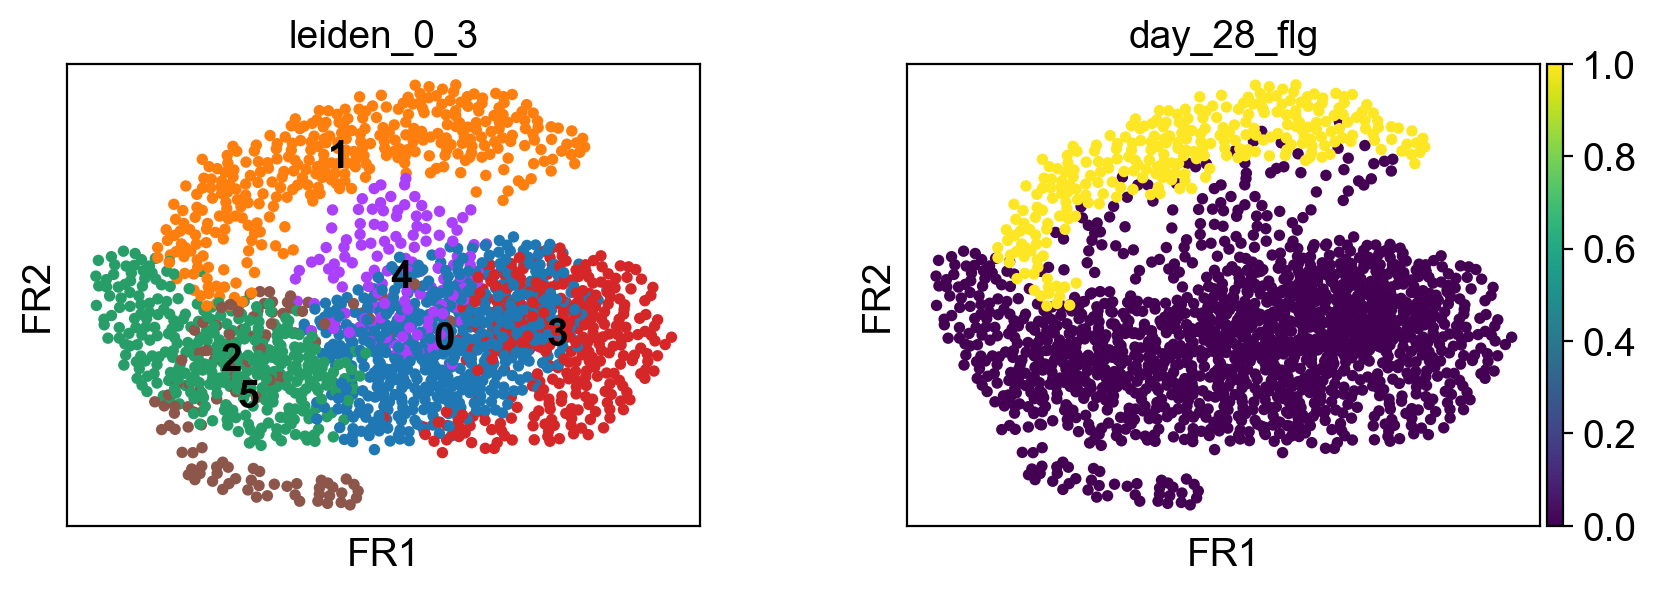

In [109]:
ep.tl.draw_graph(adata, init_pos="paga")
ep.pl.draw_graph(adata, color=["leiden_0_3", "day_28_flg"], legend_loc="on data")

_________________

## Exporting results

We save all of our computations and our final state into an `.h5ad` file. 

In [110]:
ep.io.write("mimic_2.h5ad", adata)

_________________

## Conclusion

The MIMIC-II IAC dataset comprises electronic health records (EHR) summarized in 46 features from 1776 individuals. This high dimensional data is not easy to interpret and many interesting and previously unknown features can be overseen when just focusing on selected well-defined features. To overcome this hurdle, we applied ehrapy on the MIMIC-II IAC dataset. 

ehrapy is based on the AnnData data structure and scanpy pipeline to allow for efficient analysis. We used the build-in functions to preprocess the data, perform QC with imputation of missing data and reduce the dimensionality, resulting in PCA and UMAP embeddings. After performing all these steps, we explored the data by visualizing multiple features on the UMAP embedding, giving a first glance at the patient structure. 
To identify patient groups in and unbiased fashion, we clustered our data using the Leiden algorithm resulting in 7 different patient clusters. Calculation of cluster-specific features allowed us to annotate the clusters according to the most prominent markers. We saw a strong difference between patients that deceased, had higher age and severe comorbidities such as a stroke and COPD (clusters 2+3) and those that had milder features such as increased platelets and weight (clusters 0+1). Close to these two clusters were two additional clusters that harbored more severe features such as increased heart rate (cluster 5) and high SOFA score with liver disease (cluster 6), indicating potential patient trajectories. Cluster 4 clustered apart from all the others and consists of patients that deceased several months/years after leaving the ICU. 

To explore the [patient fate](https://ehrapy.readthedocs.io/en/latest/tutorials/notebooks/mimic_2_fate.html),  [survival](https://ehrapy.readthedocs.io/en/latest/tutorials/notebooks/mimic_2_survival_analysis.html) and a [case study](https://ehrapy.readthedocs.io/en/latest/tutorials/notebooks/mimic_2_case_study.html) in more detail, continue with our other tutorials or go back to our [tutorial overview page](https://ehrapy.readthedocs.io/en/latest/tutorials/index.html). 

_________________

## References

* Raffa, J. (2016). Clinical data from the MIMIC-II database for a case study on indwelling arterial catheters (version 1.0). PhysioNet. https://doi.org/10.13026/C2NC7F.

* Raffa J.D., Ghassemi M., Naumann T., Feng M., Hsu D. (2016) Data Analysis. In: Secondary Analysis of Electronic Health Records. Springer, Cham

* Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

* McInnes et al., (2018). UMAP: Uniform Manifold Approximation and Projection. Journal of Open Source Software, 3(29), 861, https://doi.org/10.21105/joss.00861

* Traag, V.A., Waltman, L. & van Eck, N.J. From Louvain to Leiden: guaranteeing well-connected communities. Sci Rep 9, 5233 (2019). https://doi.org/10.1038/s41598-019-41695-z

* Wolf, F.A., Hamey, F.K., Plass, M. et al. PAGA: graph abstraction reconciles clustering with trajectory inference through a topology preserving map of single cells. Genome Biol 20, 59 (2019). https://doi.org/10.1186/s13059-019-1663-x

## Package versions

In [ ]:
ep.print_versions()